<a href="https://colab.research.google.com/github/mehakpreet24/CrisisLex/blob/main/FinalMilestone_StaticDataTesting_CrisisLex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#PLease uncomment only if you haven't installed these libraries

!pip install pandas networkx textblob spacy matplotlib seaborn
!python -m spacy download en_core_web_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 90.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
#Please uncomment only if you want to add the file to your drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
#Please uncomment the following line to unzip the file
#!unzip "/content/CrisisLexT26-v1.0.zip" -d "/content/drive/MyDrive/crisislext26_data"


In [ ]:
import os

DATA_DIR = "/content/drive/MyDrive/crisislext26_data/CrisisLexT26"   # or your path

print("Path exists:", os.path.exists(DATA_DIR))
print("Files:", os.listdir(DATA_DIR))


Path exists: True
Files: ['.DS_Store', '2012_Colorado_wildfires', '2012_Costa_Rica_earthquake', '2012_Guatemala_earthquake', '2012_Italy_earthquakes', '2012_Philipinnes_floods', '2012_Typhoon_Pablo', '2013_Alberta_floods', '2012_Venezuela_refinery', '2013_Bohol_earthquake', '2013_Australia_bushfire', '2013_Boston_bombings', '2013_Brazil_nightclub_fire', '2013_Colorado_floods', '2013_Glasgow_helicopter_crash', '2013_Lac_Megantic_train_crash', '2013_Queensland_floods', '2013_Manila_floods', '2013_LA_airport_shootings', '2013_NY_train_crash', '2013_Savar_building_collapse', '2013_Russia_meteor', '2013_Sardinia_floods', '2013_Spain_train_crash', '2013_Singapore_haze', '2013_Typhoon_Yolanda', '2013_West_Texas_explosion', 'README.md']


In [ ]:
import pandas as pd

sample_file = "/content/drive/MyDrive/crisislext26_data/CrisisLexT26/2012_Colorado_wildfires/2012_Colorado_wildfires-tweets_labeled.csv"
df = pd.read_csv(sample_file)
print(df.columns)


Index(['Tweet ID', ' Tweet Text', ' Information Source', ' Information Type',
       ' Informativeness'],
      dtype='object')


In [ ]:
# Remove leading/trailing spaces from column names
df.columns = df.columns.str.strip()

print(df.columns)  # Should now be clean

Index(['Tweet ID', 'Tweet Text', 'Information Source', 'Information Type',
       'Informativeness'],
      dtype='object')


In [ ]:
df.rename(columns={
    'Tweet ID': 'tweet_id',
    'Tweet Text': 'text',
    'Informativeness': 'informativeness_label',
    'Information Type': 'information_type_label'
}, inplace=True)


In [ ]:
print("Columns after rename:", df.columns)

Columns after rename: Index(['tweet_id', 'text', 'Information Source', 'information_type_label',
       'informativeness_label'],
      dtype='object')


In [ ]:
df = df.dropna(subset=['tweet_id', 'text', 'informativeness_label'])


In [ ]:
# ========================================================================================
# CrisisLexT26 Knowledge Graph Builder
# ========================================================================================

# 0. Install dependencies (run once per Colab session)
# !pip install pandas networkx textblob spacy matplotlib seaborn
# !python -m spacy download en_core_web_sm

# 1. Imports
import pandas as pd
import networkx as nx
from textblob import TextBlob
import spacy
import os
import glob
import random
import json

# 2. Configuration
DATA_DIR = "/content/drive/MyDrive/crisislext26_data/CrisisLexT26"  # Update for your Drive
GRAPH_FILE_GRAPHML = "crisis_graph.graphml"
GRAPH_FILE_JSON = "crisis_graph.json"

# 3. Initialize spaCy NLP model
try:
    nlp = spacy.load("en_core_web_sm")
except:
    print("ERROR: spaCy model 'en_core_web_sm' not found.")
    raise

# 4. Helper functions
def calculate_sentiment(text):
    """Calculates sentiment polarity using TextBlob."""
    try:
        return TextBlob(str(text)).sentiment.polarity
    except:
        return 0.0

# 5. Main function
def extract_entities_and_build_graph():
    print("\n" + "="*70)
    print("STEP 1: CRISISLEXT26 DATA INTEGRATION & GRAPH CONSTRUCTION")
    print("="*70)

    # 5a. Recursively find all labeled CSVs
    all_files = glob.glob(os.path.join(DATA_DIR, "**/*tweets_labeled*.csv"), recursive=True)
    if not all_files:
        print(f"ERROR: No labeled CSV files found in '{DATA_DIR}'.")
        return None
    print(f"Found {len(all_files)} labeled CSV files.")

    # 5b. Initialize graph
    G = nx.DiGraph()
    user_nodes_added = set()
    user_data = {}

    # 5c. Process each CSV
    for filename in all_files:
        event_name = os.path.basename(os.path.dirname(filename))  # Folder name = event
        print(f"\nProcessing event: {event_name}")
        event_id = f'E_{event_name}'
        G.add_node(event_id, type='Event', name=event_name)  # Add Event node

        # Read CSV
        df = pd.read_csv(filename)

        # Strip leading/trailing spaces from column names
        df.columns = df.columns.str.strip()

        # Rename columns to match the code
        df.rename(columns={
            'Tweet ID': 'tweet_id',
            'Tweet Text': 'text',
            'Informativeness': 'informativeness_label',
            'Information Type': 'information_type_label'
        }, inplace=True)

        # Drop rows missing required fields
        df = df.dropna(subset=['tweet_id', 'text', 'informativeness_label'])

        # Sentiment analysis
        df['sentiment_polarity'] = df['text'].apply(calculate_sentiment)

        # Entity extraction and graph construction
        for _, row in df.iterrows():
            tweet_id = str(row['tweet_id'])
            author_id = str(row.get('user_id', f'U_{hash(row["tweet_id"]) % 10000}'))

            # Add User Node
            if author_id not in user_nodes_added:
                followers = user_data.setdefault(author_id, random.randint(50, 5000))
                G.add_node(author_id, type='User', followers=followers)
                user_nodes_added.add(author_id)

            # Add Tweet/Post Node
            G.add_node(tweet_id,
                       type='Post',
                       sentiment=row['sentiment_polarity'],
                       label=row['informativeness_label'],
                       info_type=row.get('information_type_label', 'N/A'))

            # User -> Post edge
            G.add_edge(author_id, tweet_id, relationship='POSTS')
            # Post -> Event edge
            G.add_edge(tweet_id, event_id, relationship='DESCRIBES_EVENT')

            # Named Entity Recognition (NER)
            doc = nlp(row['text'])
            for ent in doc.ents:
                entity_id = f'ENT_{ent.label_}_{ent.text.replace(" ", "_")}'
                if ent.label_ in ['GPE', 'LOC']:
                    G.add_node(entity_id, type='Location', name=ent.text)
                    G.add_edge(tweet_id, entity_id, relationship='MENTIONS_LOCATION')
                elif ent.label_ == 'ORG':
                    G.add_node(entity_id, type='Organization', name=ent.text)
                    G.add_edge(tweet_id, entity_id, relationship='MENTIONS_ORG')

    # 5d. Simulate user-user FOLLOWS edges ---
    print("\nSimulating User-User (FOLLOWS) edges for PageRank...")
    user_ids = list(user_nodes_added)
    for _ in range(len(user_ids) * 5):  # 5x number of users for density
        u1, u2 = random.sample(user_ids, 2)
        G.add_edge(u1, u2, relationship='FOLLOWS')

    # 5e. Save graph in both GraphML and JSON formats ---
    print("\nSaving graph...")

    # Save as GraphML
    nx.write_graphml(G, GRAPH_FILE_GRAPHML)
    print(f" Saved GraphML: {GRAPH_FILE_GRAPHML}")

    # Save as JSON
    graph_data = nx.node_link_data(G, edges = "links")
    with open(GRAPH_FILE_JSON, 'w') as f:
        json.dump(graph_data, f, indent=2)
    print(f" Saved JSON: {GRAPH_FILE_JSON}")

    print(f"\n Graph built: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges.")

    return G

# 6. Run the graph construction
if __name__ == '__main__':
    G = extract_entities_and_build_graph()



STEP 1: CRISISLEXT26 DATA INTEGRATION & GRAPH CONSTRUCTION
Found 26 labeled CSV files.

Processing event: 2012_Colorado_wildfires

Processing event: 2012_Costa_Rica_earthquake

Processing event: 2012_Guatemala_earthquake

Processing event: 2012_Italy_earthquakes

Processing event: 2012_Philipinnes_floods

Processing event: 2012_Typhoon_Pablo

Processing event: 2013_Alberta_floods

Processing event: 2012_Venezuela_refinery

Processing event: 2013_Bohol_earthquake

Processing event: 2013_Australia_bushfire

Processing event: 2013_Boston_bombings

Processing event: 2013_Brazil_nightclub_fire

Processing event: 2013_Colorado_floods

Processing event: 2013_Glasgow_helicopter_crash

Processing event: 2013_Lac_Megantic_train_crash

Processing event: 2013_Queensland_floods

Processing event: 2013_Manila_floods

Processing event: 2013_LA_airport_shootings

Processing event: 2013_NY_train_crash

Processing event: 2013_Savar_building_collapse

Processing event: 2013_Russia_meteor

Processing eve

#Network Visualization

In [ ]:
!pip install pyvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 48.3 MB/s eta 0:00:00


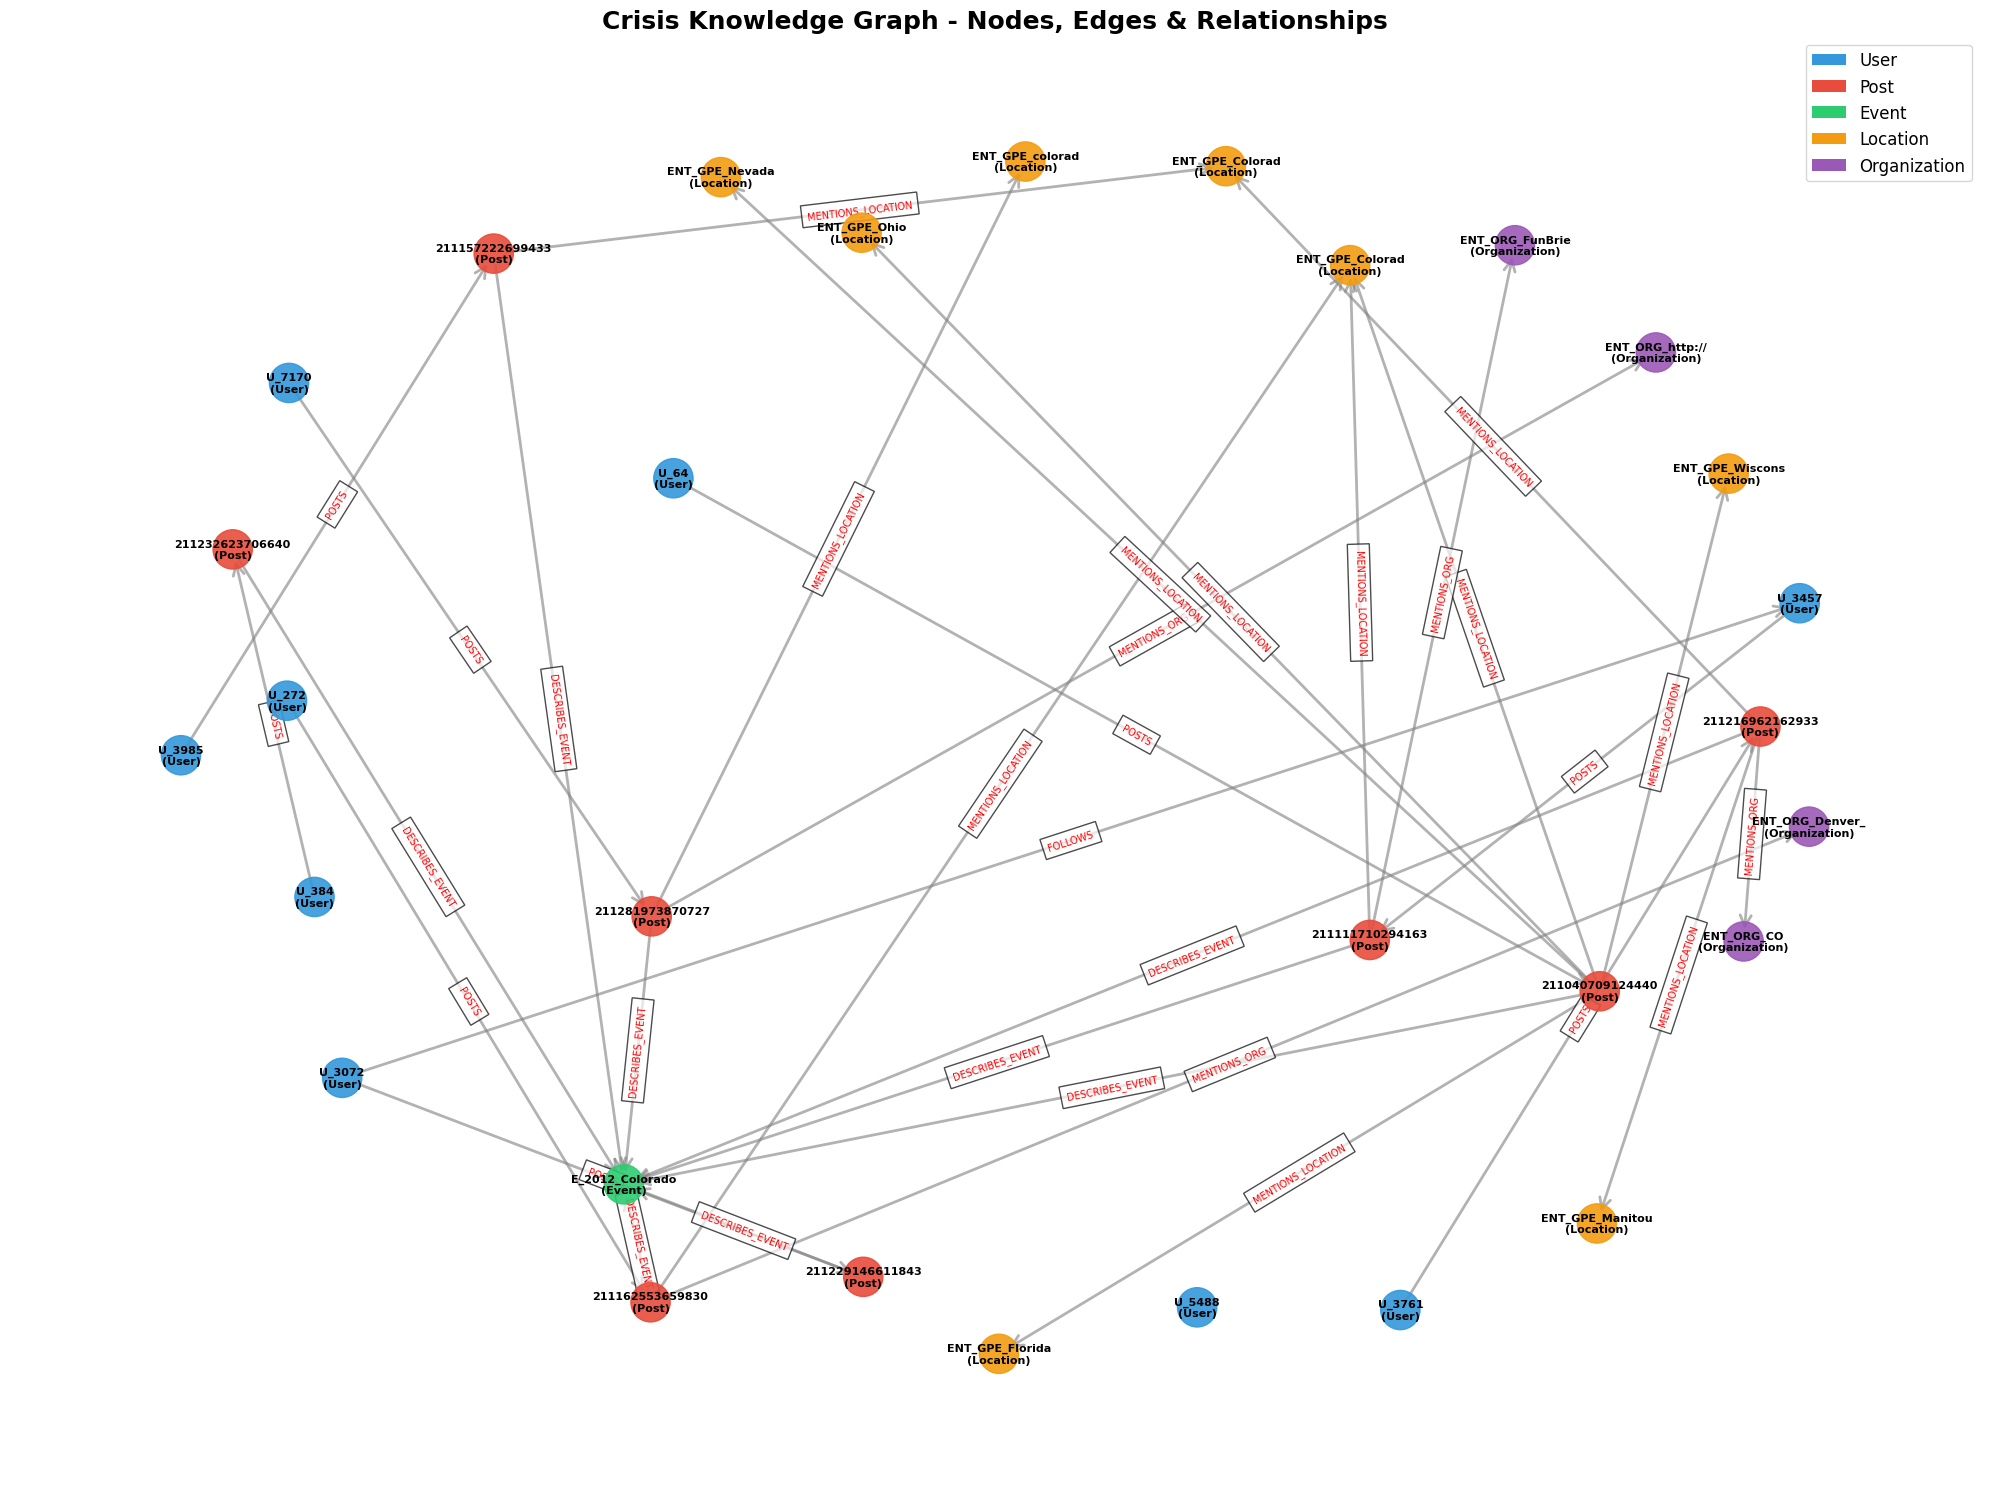


Graph Details:
Nodes shown: 30
Edges shown: 32

Sample Triples:
1. (U_3761, POSTS, 211216962162933761)
2. (211232623706640384, DESCRIBES_EVENT, E_2012_Colorado_wildfires)
3. (U_7170, POSTS, 211281973870727170)
4. (211162553659830272, DESCRIBES_EVENT, E_2012_Colorado_wildfires)
5. (211162553659830272, MENTIONS_ORG, ENT_ORG_Denver_Post)
6. (211162553659830272, MENTIONS_LOCATION, ENT_GPE_Colorado)
7. (U_272, POSTS, 211162553659830272)
8. (U_64, POSTS, 211040709124440064)
9. (211281973870727170, DESCRIBES_EVENT, E_2012_Colorado_wildfires)
10. (211281973870727170, MENTIONS_LOCATION, ENT_GPE_colorado)


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Load graph
G = nx.read_graphml('crisis_graph.graphml')

# Sample smaller graph for readability
sample_nodes = list(G.nodes())[:30]
subgraph = G.subgraph(sample_nodes)

# Color map
color_map = {
    'User': '#3498db',
    'Post': '#e74c3c',
    'Event': '#2ecc71',
    'Location': '#f39c12',
    'Organization': '#9b59b6'
}

# Get colors
colors = [color_map.get(G.nodes[n].get('type'), '#95a5a6') for n in subgraph.nodes()]

# Create figure
plt.figure(figsize=(20, 15))

# Layout
pos = nx.spring_layout(subgraph, k=2, iterations=50)

# Draw nodes
nx.draw_networkx_nodes(subgraph, pos, node_color=colors, node_size=800, alpha=0.9)

# Draw edges
nx.draw_networkx_edges(subgraph, pos, edge_color='gray', arrows=True,
                       arrowsize=20, arrowstyle='->', width=2, alpha=0.6)

# Draw node labels
node_labels = {}
for node in subgraph.nodes():
    node_type = G.nodes[node].get('type', '')
    node_labels[node] = f"{node[:15]}\n({node_type})"

nx.draw_networkx_labels(subgraph, pos, node_labels, font_size=8, font_weight='bold')

# Draw edge labels (relationships)
edge_labels = {}
for u, v, data in subgraph.edges(data=True):
    rel = data.get('relationship', 'N/A')
    edge_labels[(u, v)] = rel

nx.draw_networkx_edge_labels(subgraph, pos, edge_labels, font_size=7,
                              font_color='red', bbox=dict(facecolor='white', alpha=0.7))

# Legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=color, label=ntype)
                   for ntype, color in color_map.items()]
plt.legend(handles=legend_elements, loc='upper right', fontsize=12)

plt.title('Crisis Knowledge Graph - Nodes, Edges & Relationships', fontsize=18, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.savefig('graph.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nGraph Details:")
print(f"Nodes shown: {len(subgraph.nodes())}")
print(f"Edges shown: {len(subgraph.edges())}")
print("\nSample Triples:")
for i, (u, v, data) in enumerate(list(subgraph.edges(data=True))[:10], 1):
    rel = data.get('relationship', 'N/A')
    print(f"{i}. ({u}, {rel}, {v})")

#Network Visualization by event

Found 26 events:
1. 2012_Colorado_wildfires
2. 2012_Costa_Rica_earthquake
3. 2012_Guatemala_earthquake
4. 2012_Italy_earthquakes
5. 2012_Philipinnes_floods
6. 2012_Typhoon_Pablo
7. 2013_Alberta_floods
8. 2012_Venezuela_refinery
9. 2013_Bohol_earthquake
10. 2013_Australia_bushfire
11. 2013_Boston_bombings
12. 2013_Brazil_nightclub_fire
13. 2013_Colorado_floods
14. 2013_Glasgow_helicopter_crash
15. 2013_Lac_Megantic_train_crash
16. 2013_Queensland_floods
17. 2013_Manila_floods
18. 2013_LA_airport_shootings
19. 2013_NY_train_crash
20. 2013_Savar_building_collapse
21. 2013_Russia_meteor
22. 2013_Sardinia_floods
23. 2013_Spain_train_crash
24. 2013_Singapore_haze
25. 2013_Typhoon_Yolanda
26. 2013_West_Texas_explosion

Visualizing event: 2012_Colorado_wildfires

Subgraph contains:
  1 Event: 2012_Colorado_wildfires
  50 Posts
  47 Users
  22 Locations
  26 Organizations


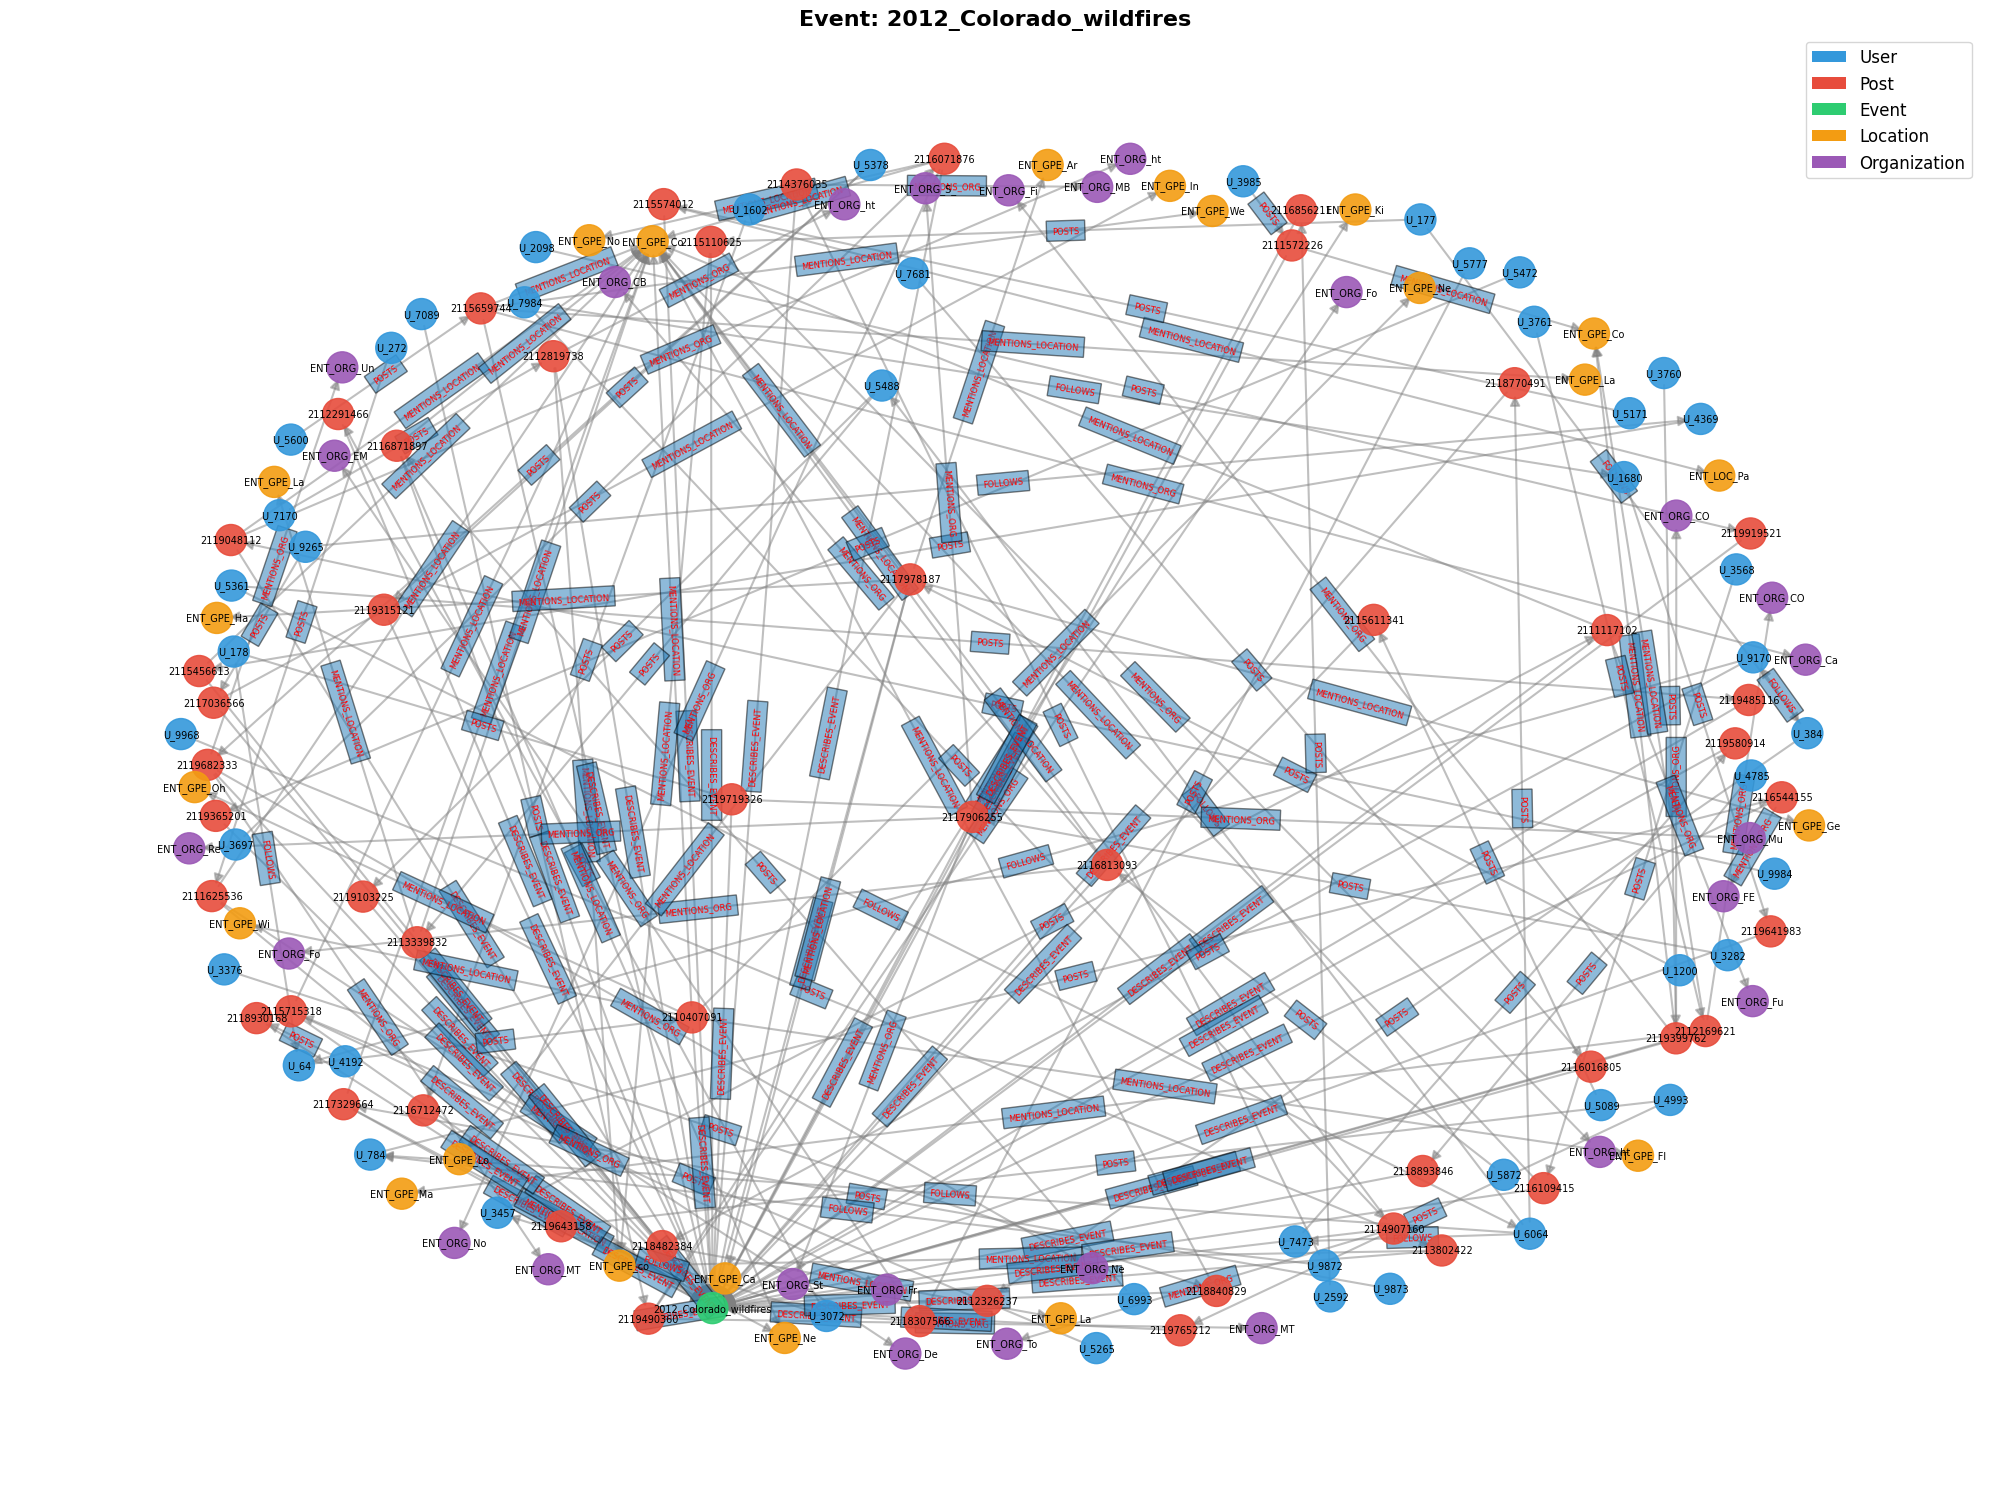


Saved: event_2012_Colorado_wildfires.png


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Load graph
G = nx.read_graphml('crisis_graph.graphml')

# Get all events
event_nodes = [n for n, d in G.nodes(data=True) if d.get('type') == 'Event']
print(f"Found {len(event_nodes)} events:")
for i, event in enumerate(event_nodes, 1):
    event_name = G.nodes[event].get('name', event)
    print(f"{i}. {event_name}")

# Pick one event (change index to select different event)
selected_event = event_nodes[0]  # Change 0 to 1, 2, 3... for different events
event_name = G.nodes[selected_event].get('name', selected_event)

print(f"\nVisualizing event: {event_name}")

# Get all posts connected to this event
posts = list(G.predecessors(selected_event))[:50]  # Limit to 50 posts

# Get users who posted those tweets
users = []
for post in posts:
    users.extend(list(G.predecessors(post)))

# Get locations and organizations mentioned in posts
locations = []
organizations = []
for post in posts:
    for neighbor in G.successors(post):
        node_type = G.nodes[neighbor].get('type')
        if node_type == 'Location':
            locations.append(neighbor)
        elif node_type == 'Organization':
            organizations.append(neighbor)

# Build subgraph
nodes_to_show = [selected_event] + posts + users + locations + organizations
subgraph = G.subgraph(nodes_to_show)

print(f"\nSubgraph contains:")
print(f"  1 Event: {event_name}")
print(f"  {len(posts)} Posts")
print(f"  {len(set(users))} Users")
print(f"  {len(set(locations))} Locations")
print(f"  {len(set(organizations))} Organizations")

# Color map
color_map = {
    'User': '#3498db',
    'Post': '#e74c3c',
    'Event': '#2ecc71',
    'Location': '#f39c12',
    'Organization': '#9b59b6'
}

colors = [color_map.get(G.nodes[n].get('type'), '#95a5a6') for n in subgraph.nodes()]

# Visualize
plt.figure(figsize=(20, 15))

pos = nx.spring_layout(subgraph, k=1.5, iterations=50)

# Draw nodes
nx.draw_networkx_nodes(subgraph, pos, node_color=colors, node_size=500, alpha=0.9)

# Draw edges
nx.draw_networkx_edges(subgraph, pos, edge_color='gray', arrows=True,
                       arrowsize=15, width=1.5, alpha=0.5)

# Node labels
node_labels = {}
for node in subgraph.nodes():
    node_type = G.nodes[node].get('type', '')
    if node_type == 'Event':
        node_labels[node] = f"{event_name}"
    else:
        node_labels[node] = f"{node[:10]}"

nx.draw_networkx_labels(subgraph, pos, node_labels, font_size=7)

# Edge labels
edge_labels = {}
for u, v, data in subgraph.edges(data=True):
    rel = data.get('relationship', '')
    edge_labels[(u, v)] = rel

nx.draw_networkx_edge_labels(subgraph, pos, edge_labels, font_size=6,
                              font_color='red', bbox=dict(alpha=0.5))

# Legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=color, label=ntype)
                   for ntype, color in color_map.items()]
plt.legend(handles=legend_elements, loc='upper right', fontsize=12)

plt.title(f'Event: {event_name}', fontsize=16, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.savefig(f'event_{event_name}.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nSaved: event_{event_name}.png")

#Node Analaytics

In [ ]:
import networkx as nx
import pandas as pd

# Load the graph
G = nx.read_graphml('crisis_graph.graphml')

# Get the event node
event_nodes = [n for n, d in G.nodes(data=True) if d.get('type') == 'Event']
selected_event = event_nodes[0]
event_name = G.nodes[selected_event].get('name', selected_event)

# Build subgraph around the event
all_event_posts = list(G.predecessors(selected_event))
event_users = []
for post in all_event_posts:
    event_users.extend(list(G.predecessors(post)))
event_users = list(set(event_users))

event_locations = []
event_orgs = []
for post in all_event_posts:
    for neighbor in G.successors(post):
        ntype = G.nodes[neighbor].get('type')
        if ntype == 'Location':
            event_locations.append(neighbor)
        elif ntype == 'Organization':
            event_orgs.append(neighbor)

event_locations = list(set(event_locations))
event_orgs = list(set(event_orgs))

event_subgraph_nodes = [selected_event] + all_event_posts + event_users + event_locations + event_orgs
subgraph = G.subgraph(event_subgraph_nodes)

print(f"Analyzing event: {event_name}")
print(f"Nodes: {subgraph.number_of_nodes()}, Users: {len(event_users)}, Posts: {len(all_event_posts)}")

# Calculate centrality measures
in_degree = dict(subgraph.in_degree())
out_degree = dict(subgraph.out_degree())
pagerank = nx.pagerank(subgraph)
betweenness = nx.betweenness_centrality(subgraph)

results = []

for node in subgraph.nodes():
    node_data = G.nodes[node]
    node_type = node_data.get('type', 'Unknown')

    row = {
        'event': event_name,
        'node': node,
        'entity_type': node_type,
        'node_name': node_data.get('name', node),
        'in_degree': in_degree[node],
        'out_degree': out_degree[node],
        'total_degree': in_degree[node] + out_degree[node]
    }

    if node_type == 'User':
        user_posts = list(subgraph.successors(node))
        reached_entities = set()
        total_entities_mentioned = 0
        for post in user_posts:
            entities = list(subgraph.successors(post))
            reached_entities.update(entities)
            total_entities_mentioned += len(entities)

        row.update({
            'user_activity': len(user_posts),
            'user_reach': len(reached_entities),
            'user_avg_entities_per_post': total_entities_mentioned / max(len(user_posts), 1),
            'meaningful_metric': len(user_posts) * len(reached_entities)
        })

    elif node_type == 'Post':
        row.update({
            'post_betweenness': betweenness[node],
            'post_entity_count': out_degree[node] - 1,
            'meaningful_metric': betweenness[node]
        })

    elif node_type in ['Location', 'Organization']:
        row.update({
            'entity_pagerank': pagerank[node],
            'entity_mentions': in_degree[node],
            'meaningful_metric': pagerank[node]
        })

    elif node_type == 'Event':
        row.update({
            'event_size': in_degree[node],
            'event_pagerank': pagerank[node],
            'meaningful_metric': in_degree[node]
        })

    else:
        row.update({'meaningful_metric': 0})

    results.append(row)

df = pd.DataFrame(results)

# Save to CSV
csv_file = f"{event_name.replace(' ', '_')}_centrality.csv"
df.to_csv(csv_file, index=False)
print(f"\nSaved results to {csv_file}")

# Display top nodes by type
print("\nTop Users (by Activity x Reach):")
top_users = df[df['entity_type'] == 'User'].nlargest(10, 'meaningful_metric')
for idx, row in top_users.iterrows():
    print(f"  {row['node'][:50]}: Posts={row['user_activity']}, Reach={row['user_reach']}")

print("\nTop Posts (by Betweenness):")
top_posts = df[df['entity_type'] == 'Post'].nlargest(10, 'meaningful_metric')
for idx, row in top_posts.iterrows():
    print(f"  {row['node'][:50]}: Betweenness={row['meaningful_metric']:.6f}")

print("\nTop Locations (by PageRank):")
top_locs = df[df['entity_type'] == 'Location'].nlargest(10, 'meaningful_metric')
for idx, row in top_locs.iterrows():
    print(f"  {row['node'][:50]}: PageRank={row['meaningful_metric']:.6f}")

print("\nTop Organizations (by PageRank):")
top_orgs = df[df['entity_type'] == 'Organization'].nlargest(10, 'meaningful_metric')
for idx, row in top_orgs.iterrows():
    print(f"  {row['node'][:50]}: PageRank={row['meaningful_metric']:.6f}")

Analyzing event: 2012_Colorado_wildfires
Nodes: 2286, Users: 571, Posts: 1200

Saved results to 2012_Colorado_wildfires_centrality.csv

Top Users (by Activity x Reach):
  U_3072: Posts=9.0, Reach=37.0
  U_8176: Posts=10.0, Reach=33.0
  U_5376: Posts=10.0, Reach=32.0
  U_1169: Posts=11.0, Reach=27.0
  U_7504: Posts=9.0, Reach=33.0
  U_1184: Posts=10.0, Reach=29.0
  U_9872: Posts=9.0, Reach=32.0
  U_1457: Posts=11.0, Reach=25.0
  U_1376: Posts=9.0, Reach=30.0
  U_6672: Posts=9.0, Reach=29.0

Top Posts (by Betweenness):
  218406703857811457: Betweenness=0.000513
  211797818766131200: Betweenness=0.000373
  218065274962841600: Betweenness=0.000352
  215426868973801473: Betweenness=0.000342
  211040709124440064: Betweenness=0.000328
  216741565182386176: Betweenness=0.000264
  211565974422425600: Betweenness=0.000258
  215694696259919872: Betweenness=0.000257
  218412684947890179: Betweenness=0.000257
  216654818595450882: Betweenness=0.000257

Top Locations (by PageRank):
  ENT_GPE_Colorad

What the Event Network Visualization Shows
The structure of conversation around a crisis event
1.   The most active users (ranked by post volume)
2.   Which locations and organizations are most frequently mentioned
3.   How posts, users, and entities are interconnected
4.   A high-level view of engagement patterns during the event

Analyzing: 2012_Colorado_wildfires
Nodes: 2286, Edges: 5027

Top 10 users:
  1. U_2592: 8 posts
  2. U_1457: 8 posts
  3. U_7568: 7 posts
  4. U_1264: 7 posts
  5. U_9088: 7 posts
  6. U_3360: 6 posts
  7. U_1904: 6 posts
  8. U_9488: 6 posts
  9. U_8272: 6 posts
  10. U_1984: 6 posts

Creating visualization...

Saved: 2012_Colorado_wildfires_network.png


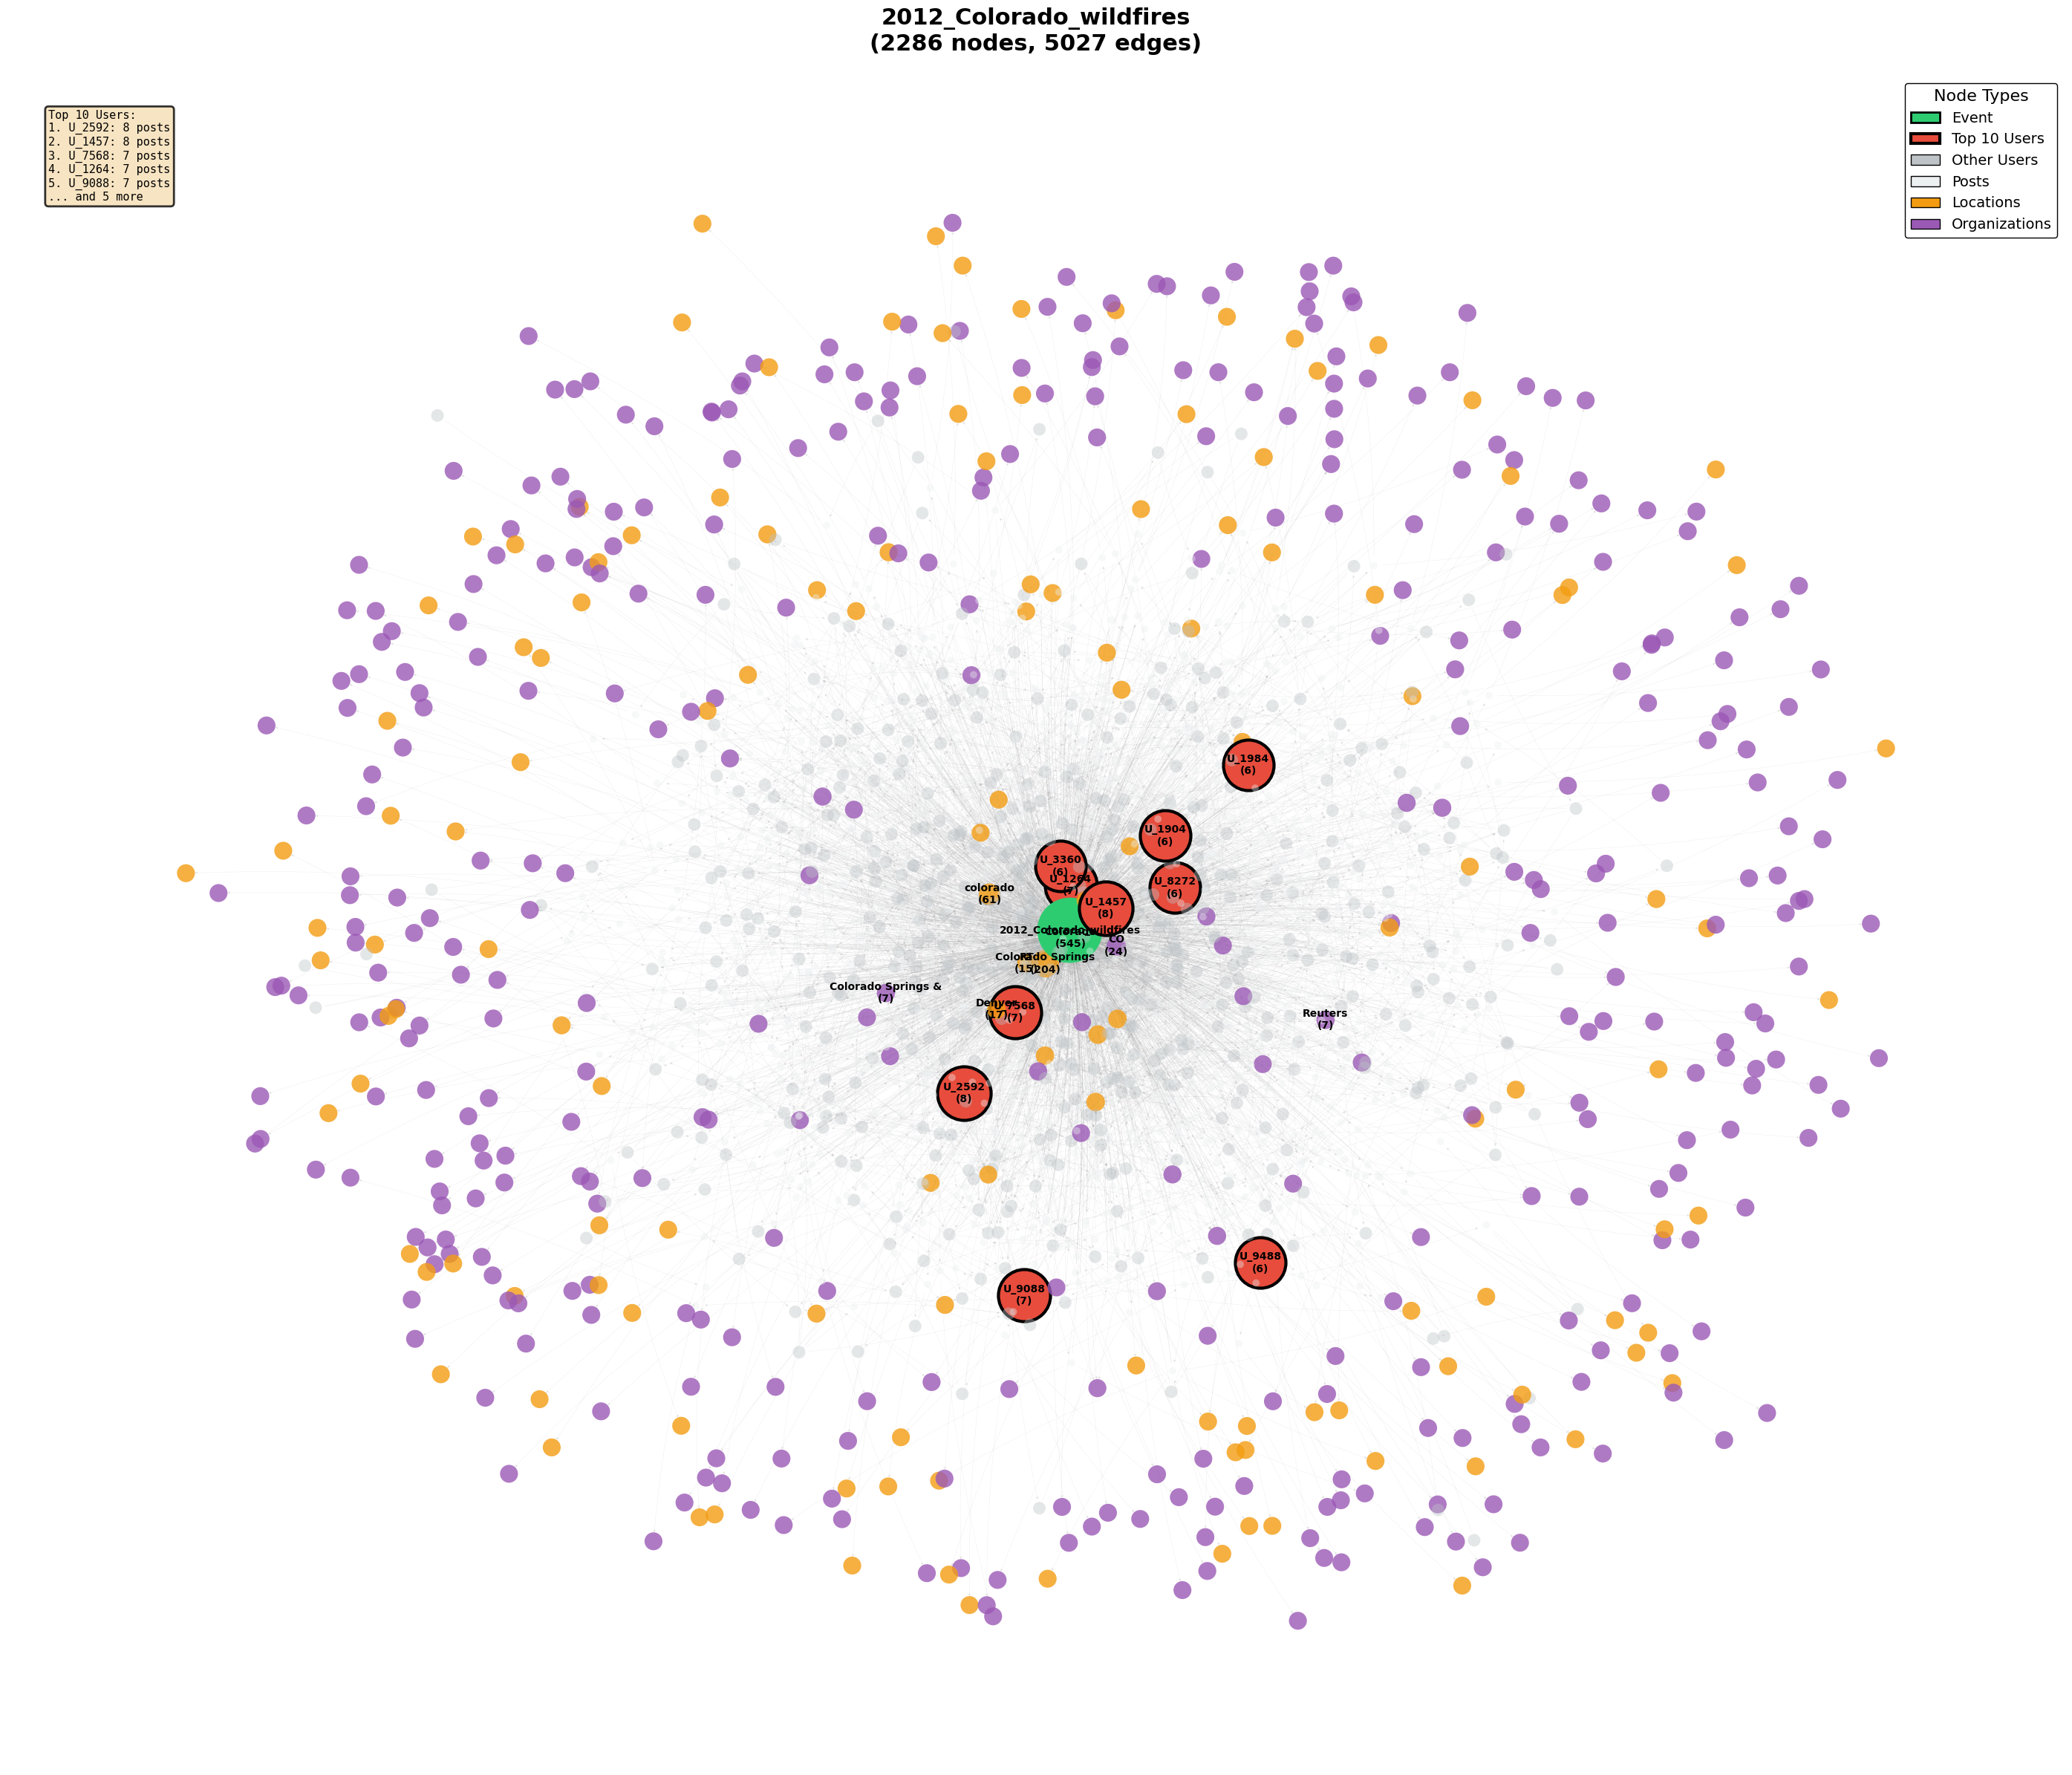


Creating zoomed view...
Saved: 2012_Colorado_wildfires_zoom.png


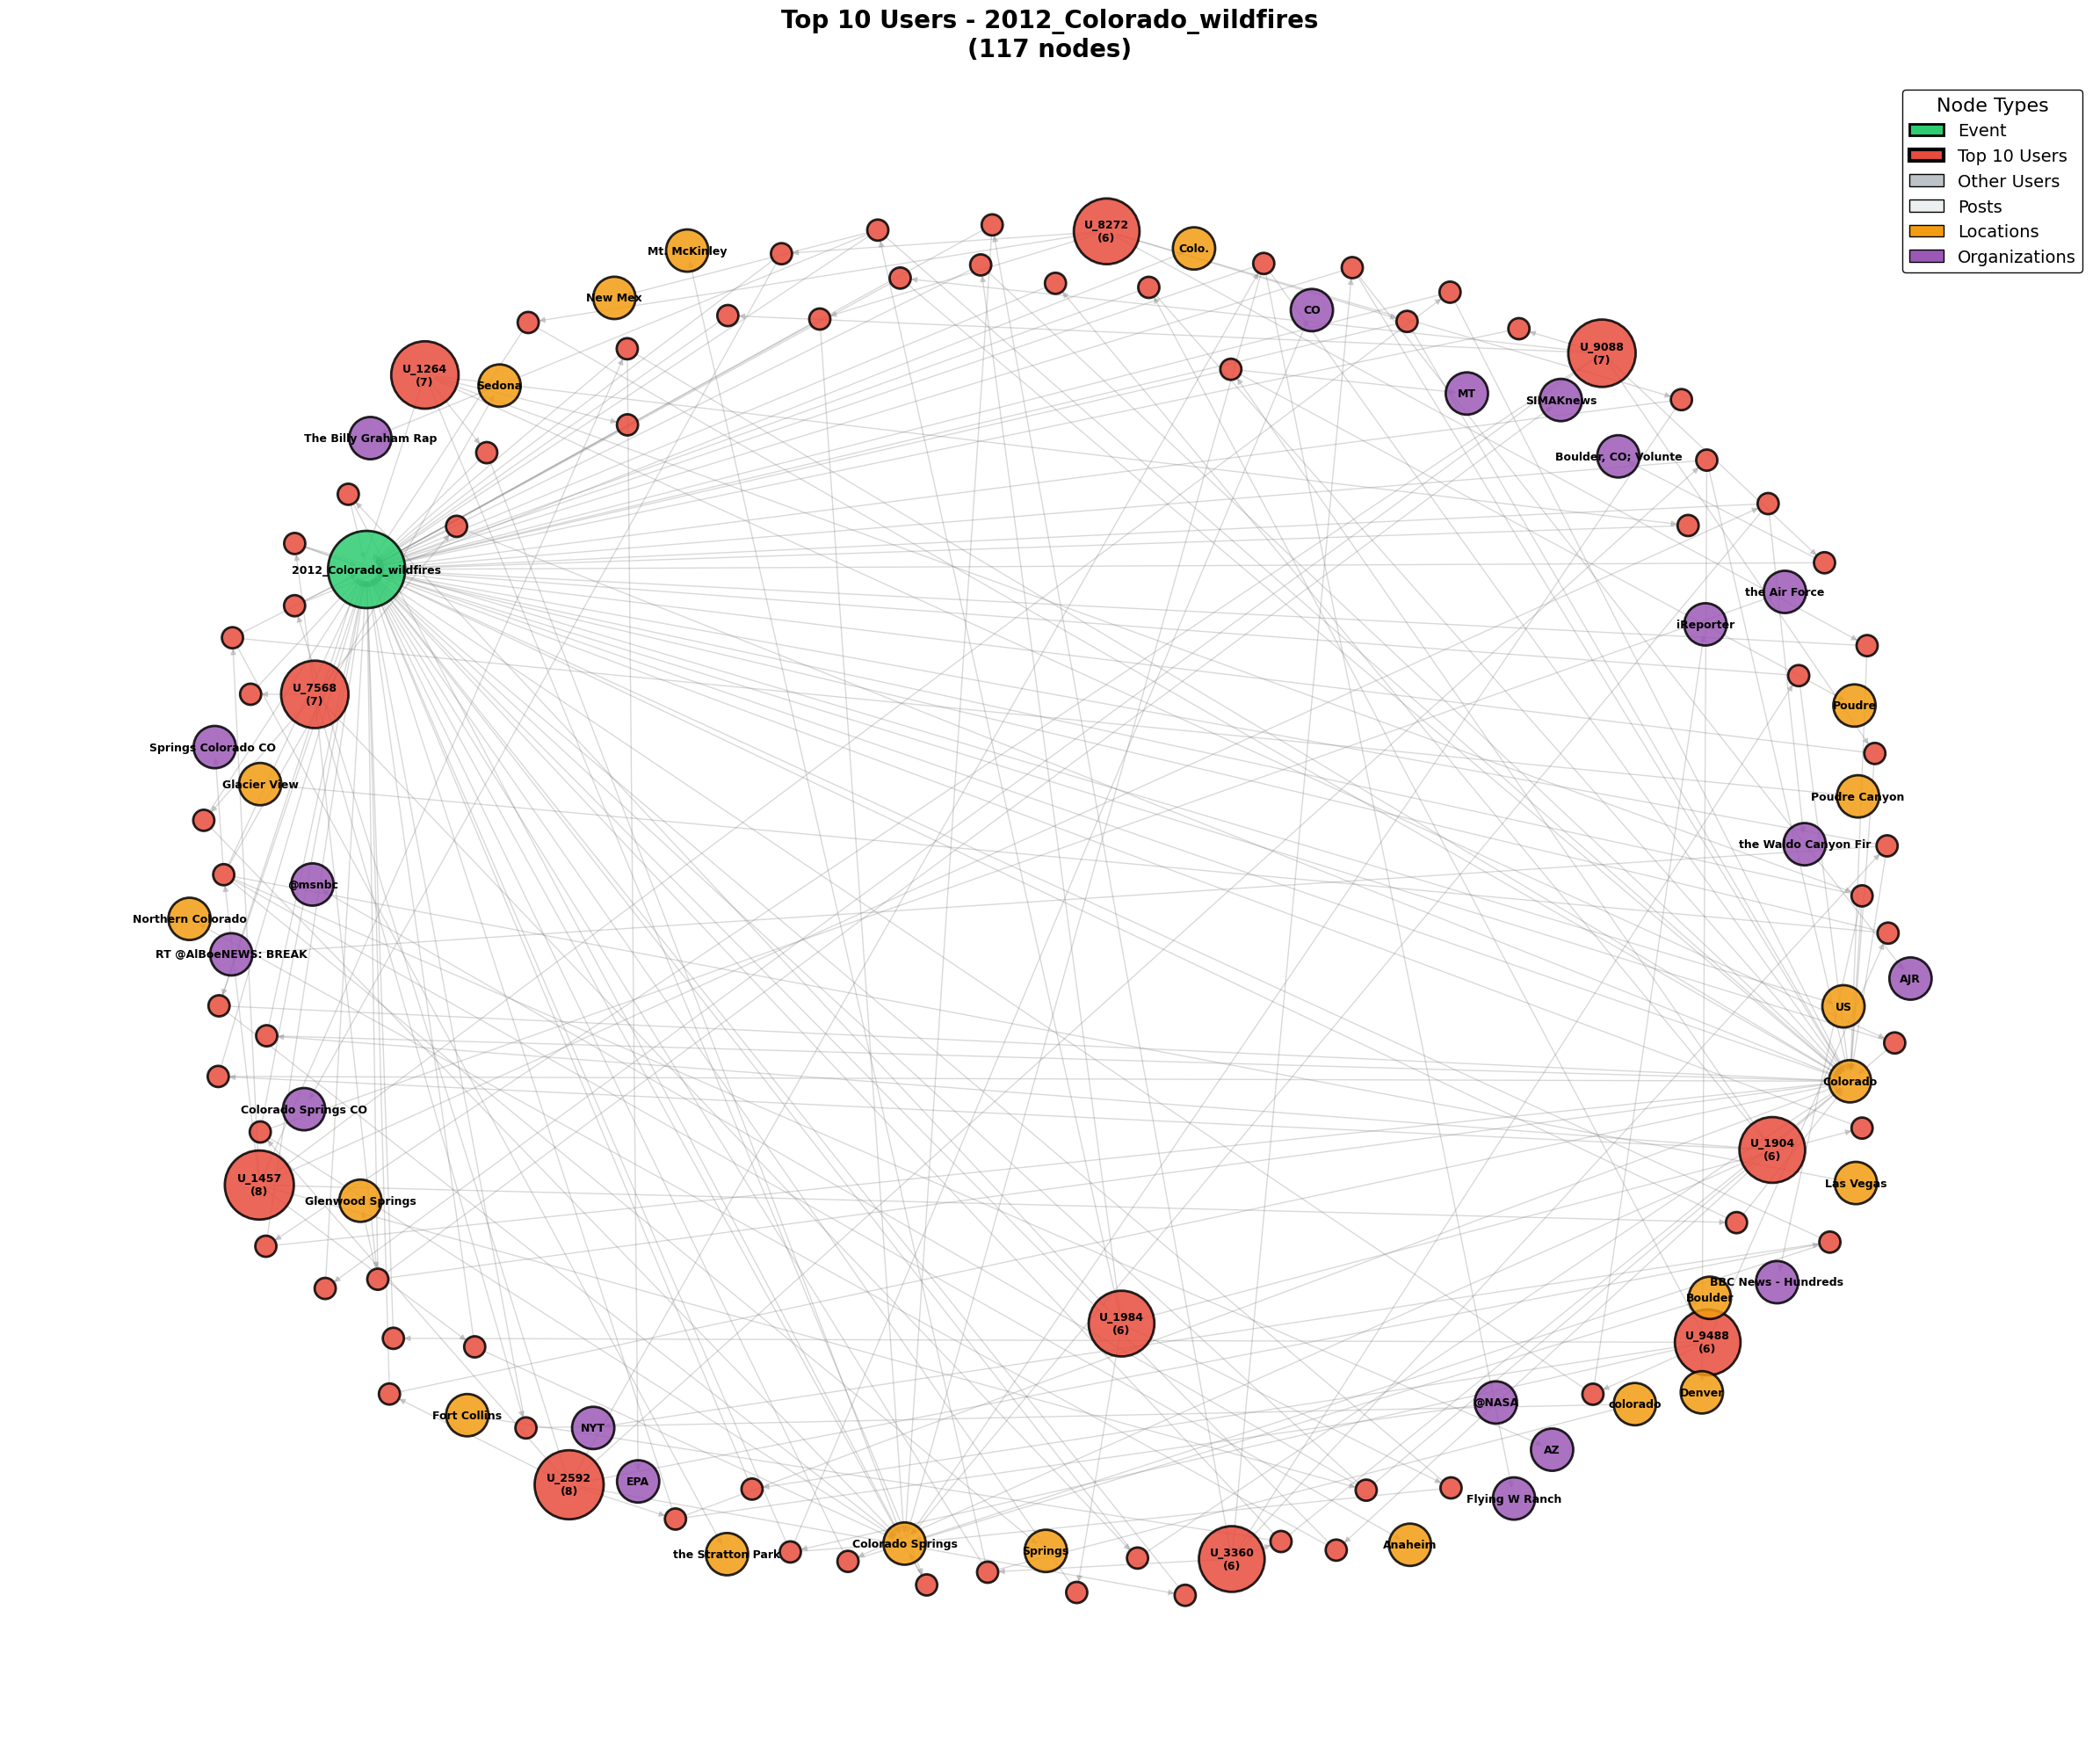

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from collections import Counter

# Load graph
G = nx.read_graphml('crisis_graph.graphml')

# Get the event
event_nodes = [n for n, d in G.nodes(data=True) if d.get('type') == 'Event']
selected_event = event_nodes[0]
event_name = G.nodes[selected_event].get('name', selected_event)

print(f"Analyzing: {event_name}")

# Build full event subgraph
event_posts = list(G.predecessors(selected_event))
event_users = []
for post in event_posts:
    event_users.extend(list(G.predecessors(post)))
event_users = list(set(event_users))

event_locations = []
event_orgs = []
for post in event_posts:
    for neighbor in G.successors(post):
        ntype = G.nodes[neighbor].get('type')
        if ntype == 'Location':
            event_locations.append(neighbor)
        elif ntype == 'Organization':
            event_orgs.append(neighbor)

event_locations = list(set(event_locations))
event_orgs = list(set(event_orgs))

full_event_nodes = [selected_event] + event_posts + event_users + event_locations + event_orgs
full_subgraph = G.subgraph(full_event_nodes)

print(f"Nodes: {full_subgraph.number_of_nodes()}, Edges: {full_subgraph.number_of_edges()}")

# Find top users by post count
user_post_count = {}
for user in event_users:
    user_posts = [p for p in G.successors(user) if p in event_posts]
    user_post_count[user] = len(user_posts)

TOP_N = 10
top_users = sorted(user_post_count.items(), key=lambda x: x[1], reverse=True)[:TOP_N]
top_user_nodes = [user for user, _ in top_users]

print(f"\nTop {TOP_N} users:")
for i, (user, count) in enumerate(top_users, 1):
    print(f"  {i}. {user[:50]}: {count} posts")

# Create visualization
print("\nCreating visualization...")
fig, ax = plt.subplots(figsize=(28, 24))

pos = nx.spring_layout(full_subgraph, k=1.5, iterations=50, seed=42)

# Set node colors and sizes
base_color_map = {
    'Event': '#2ecc71',
    'User': '#bdc3c7',
    'Post': '#ecf0f1',
    'Location': '#f39c12',
    'Organization': '#9b59b6'
}

TOP_USER_COLOR = '#e74c3c'

node_colors = []
node_sizes = []
node_alphas = []

for node in full_subgraph.nodes():
    node_type = G.nodes[node].get('type', 'Unknown')

    if node_type == 'User' and node in top_user_nodes:
        node_colors.append(TOP_USER_COLOR)
    else:
        node_colors.append(base_color_map.get(node_type, '#95a5a6'))

    if node_type == 'Event':
        node_sizes.append(4000)
    elif node_type == 'User':
        if node in top_user_nodes:
            posts = user_post_count.get(node, 1)
            node_sizes.append(1500 + posts * 150)
        else:
            node_sizes.append(150)
    elif node_type == 'Location':
        mentions = sum(1 for p in event_posts if node in G.successors(p))
        node_sizes.append(300 + mentions * 2)
    elif node_type == 'Organization':
        mentions = sum(1 for p in event_posts if node in G.successors(p))
        node_sizes.append(300 + mentions * 2)
    else:
        node_sizes.append(50)

    if node_type == 'User' and node in top_user_nodes:
        node_alphas.append(1.0)
    elif node_type == 'Event':
        node_alphas.append(1.0)
    elif node_type in ['Location', 'Organization']:
        node_alphas.append(0.8)
    else:
        node_alphas.append(0.4)

# Draw network
nx.draw_networkx_edges(full_subgraph, pos, edge_color='gray', width=0.3,
                       alpha=0.15, arrows=True, arrowsize=5,
                       connectionstyle='arc3,rad=0.05', ax=ax)

for i, node in enumerate(full_subgraph.nodes()):
    nx.draw_networkx_nodes(full_subgraph, pos, nodelist=[node],
                          node_color=[node_colors[i]], node_size=[node_sizes[i]],
                          alpha=node_alphas[i],
                          edgecolors='black' if G.nodes[node].get('type') == 'User' and node in top_user_nodes else 'none',
                          linewidths=3 if node in top_user_nodes else 0, ax=ax)

# Add labels
labels = {}
labels[selected_event] = G.nodes[selected_event].get('name', selected_event)

for user in top_user_nodes:
    posts = user_post_count[user]
    labels[user] = f"{user[:15]}\n({posts})"

location_counts = Counter()
for post in event_posts:
    for loc in event_locations:
        if loc in G.successors(post):
            location_counts[loc] += 1

for loc, count in location_counts.most_common(5):
    loc_name = G.nodes[loc].get('name', loc)
    labels[loc] = f"{loc_name[:20]}\n({count})"

org_counts = Counter()
for post in event_posts:
    for org in event_orgs:
        if org in G.successors(post):
            org_counts[org] += 1

for org, count in org_counts.most_common(3):
    org_name = G.nodes[org].get('name', org)
    labels[org] = f"{org_name[:20]}\n({count})"

nx.draw_networkx_labels(full_subgraph, pos, labels, font_size=10,
                       font_weight='bold', font_color='black', ax=ax)

# Updated legend with fully visible colors
legend_elements = [
    mpatches.Patch(facecolor='#2ecc71', edgecolor='black', linewidth=2, label='Event'),
    mpatches.Patch(facecolor=TOP_USER_COLOR, edgecolor='black', linewidth=3, label=f'Top {TOP_N} Users'),
    mpatches.Patch(facecolor='#bdc3c7', edgecolor='black', linewidth=1, label='Other Users'),
    mpatches.Patch(facecolor='#ecf0f1', edgecolor='black', linewidth=1, label='Posts'),
    mpatches.Patch(facecolor='#f39c12', edgecolor='black', linewidth=1, label='Locations'),
    mpatches.Patch(facecolor='#9b59b6', edgecolor='black', linewidth=1, label='Organizations'),
]

ax.legend(handles=legend_elements, loc='upper right', fontsize=14,
         title='Node Types', title_fontsize=16, framealpha=1.0,
         edgecolor='black', fancybox=True)

title = f'{event_name}\n({full_subgraph.number_of_nodes()} nodes, {full_subgraph.number_of_edges()} edges)'
ax.set_title(title, fontsize=22, fontweight='bold', pad=25)

textstr = f"Top {TOP_N} Users:\n"
for i, (user, count) in enumerate(top_users[:5], 1):
    textstr += f"{i}. {user[:20]}: {count} posts\n"
if len(top_users) > 5:
    textstr += f"... and {len(top_users)-5} more"

props = dict(boxstyle='round', facecolor='wheat', alpha=0.8, edgecolor='black', linewidth=2)
ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=props, family='monospace')

ax.axis('off')
plt.tight_layout()

filename = f"{event_name.replace(' ', '_')}_network.png"
plt.savefig(filename, dpi=300, bbox_inches='tight', facecolor='white')
print(f"\nSaved: {filename}")
plt.show()

# Create zoomed visualization
print("\nCreating zoomed view...")
fig, ax = plt.subplots(figsize=(24, 20))

zoom_nodes = set(top_user_nodes)
zoom_nodes.add(selected_event)

for user in top_user_nodes:
    zoom_nodes.update([p for p in G.successors(user) if p in event_posts])

for user in top_user_nodes:
    for post in [p for p in G.successors(user) if p in event_posts]:
        zoom_nodes.update(G.successors(post))

zoom_subgraph = G.subgraph(zoom_nodes)
pos_zoom = nx.spring_layout(zoom_subgraph, k=3, iterations=50, seed=42)

zoom_colors = []
zoom_sizes = []

for node in zoom_subgraph.nodes():
    node_type = G.nodes[node].get('type', 'Unknown')

    if node_type == 'User' and node in top_user_nodes:
        zoom_colors.append(TOP_USER_COLOR)
        posts = user_post_count.get(node, 1)
        zoom_sizes.append(2000 + posts * 150)
    elif node_type == 'Event':
        zoom_colors.append('#2ecc71')
        zoom_sizes.append(4000)
    elif node_type == 'Location':
        zoom_colors.append('#f39c12')
        zoom_sizes.append(1200)
    elif node_type == 'Organization':
        zoom_colors.append('#9b59b6')
        zoom_sizes.append(1200)
    else:
        zoom_colors.append('#e74c3c')
        zoom_sizes.append(300)

nx.draw_networkx_edges(zoom_subgraph, pos_zoom, edge_color='gray', width=1,
                       alpha=0.3, arrows=True, arrowsize=10, ax=ax)

nx.draw_networkx_nodes(zoom_subgraph, pos_zoom, node_color=zoom_colors,
                       node_size=zoom_sizes, alpha=0.85, edgecolors='black',
                       linewidths=2, ax=ax)

zoom_labels = {}
for node in zoom_subgraph.nodes():
    node_type = G.nodes[node].get('type')
    if node_type == 'Event':
        zoom_labels[node] = G.nodes[node].get('name', node)
    elif node_type == 'User' and node in top_user_nodes:
        posts = user_post_count[node]
        zoom_labels[node] = f"{node[:15]}\n({posts})"
    elif node_type in ['Location', 'Organization']:
        zoom_labels[node] = G.nodes[node].get('name', node)[:20]

nx.draw_networkx_labels(zoom_subgraph, pos_zoom, zoom_labels, font_size=9,
                       font_weight='bold', ax=ax)

ax.legend(handles=legend_elements, loc='upper right', fontsize=14,
         title='Node Types', title_fontsize=16, framealpha=0.95,
         edgecolor='black', fancybox=True)

ax.set_title(f'Top {TOP_N} Users - {event_name}\n({zoom_subgraph.number_of_nodes()} nodes)',
            fontsize=20, fontweight='bold', pad=20)

ax.axis('off')
plt.tight_layout()

zoom_filename = f"{event_name.replace(' ', '_')}_zoom.png"
plt.savefig(zoom_filename, dpi=300, bbox_inches='tight', facecolor='white')
print(f"Saved: {zoom_filename}")
plt.show()

#Sentiment distribution across all events

Analyzed 27933 posts across 26 events



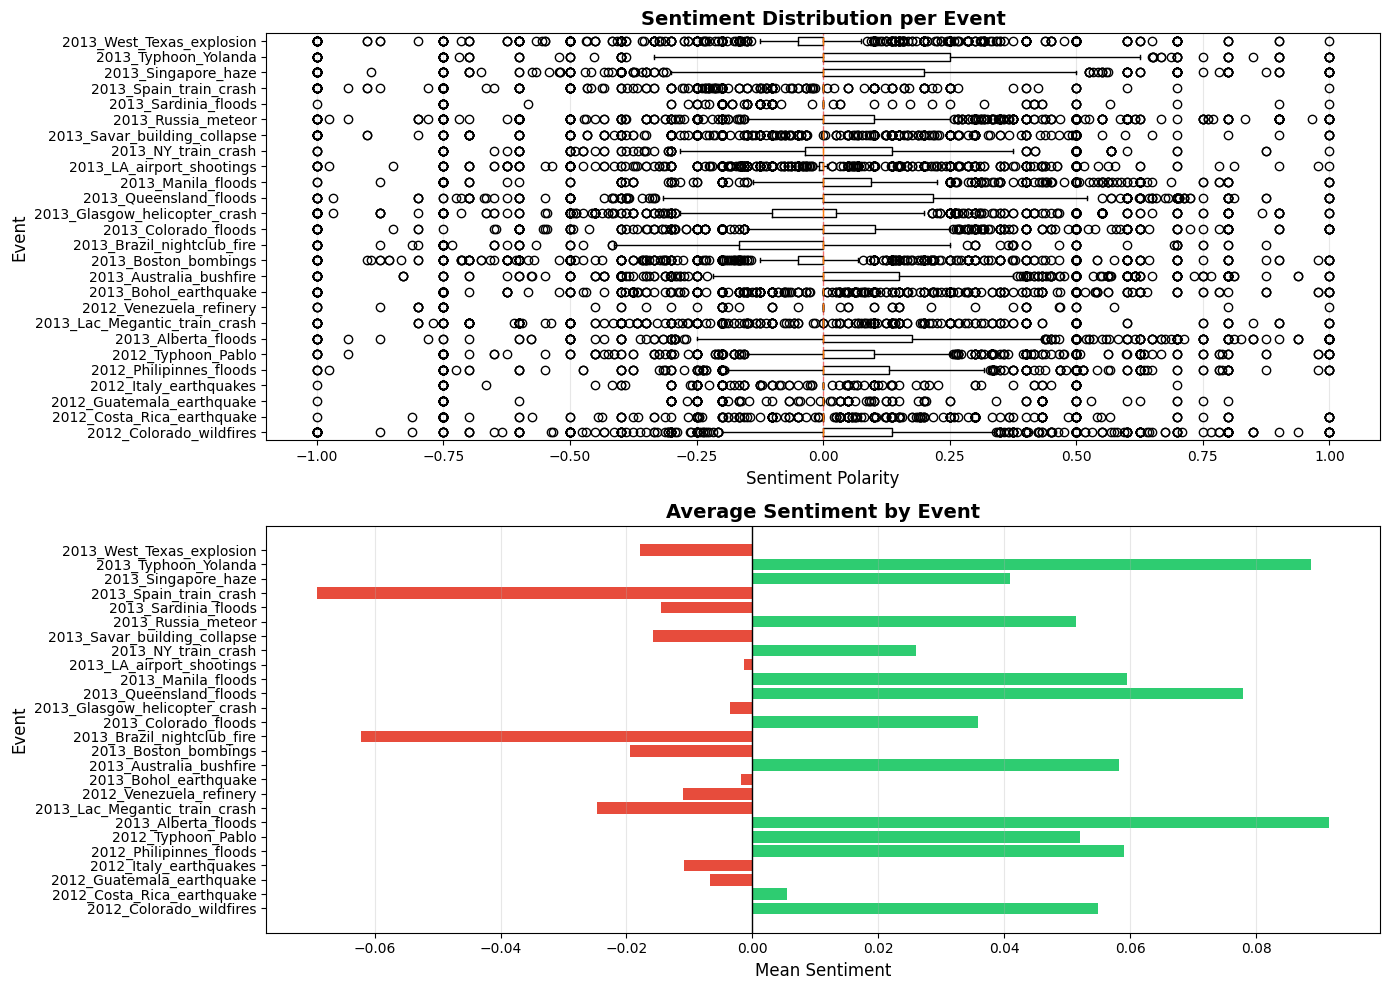


Analysis complete!


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Collect sentiment data per event
event_sentiments = {}
event_post_data = []

for n, d in G.nodes(data=True):
    if d.get('type') == 'Post':
        sentiment = d.get('sentiment', 0)

        # Find the event this post belongs to
        events = [v for u, v, e in G.edges(n, data=True) if e.get('relationship') == 'DESCRIBES_EVENT']

        for event in events:
            event_name = G.nodes[event].get('name', event)
            event_sentiments.setdefault(event_name, []).append(sentiment)

            event_post_data.append({
                'event': event_name,
                'post': n,
                'sentiment': sentiment
            })

print(f"Analyzed {len(event_post_data)} posts across {len(event_sentiments)} events\n")

# Create DataFrame
df = pd.DataFrame(event_post_data)

# Visualization 1: Boxplot per event
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

ax1 = axes[0]
box_data = [event_sentiments[e] for e in event_sentiments]
box_labels = list(event_sentiments.keys())
ax1.boxplot(box_data, tick_labels=box_labels, vert=False)
ax1.set_xlabel("Sentiment Polarity", fontsize=12)
ax1.set_ylabel("Event", fontsize=12)
ax1.set_title("Sentiment Distribution per Event", fontsize=14, fontweight='bold')
ax1.axvline(x=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
ax1.grid(True, alpha=0.3, axis='x')

# Visualization 2: Bar chart of mean sentiment
ax2 = axes[1]
event_means = {event: np.mean(sents) for event, sents in event_sentiments.items()}
events = list(event_means.keys())
means = list(event_means.values())
colors = ['#2ecc71' if m > 0 else '#e74c3c' for m in means]

ax2.barh(events, means, color=colors)
ax2.set_xlabel("Mean Sentiment", fontsize=12)
ax2.set_ylabel("Event", fontsize=12)
ax2.set_title("Average Sentiment by Event", fontsize=14, fontweight='bold')
ax2.axvline(x=0, color='black', linestyle='-', linewidth=1)
ax2.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("\nAnalysis complete!")

#Answering RQ's

Step 1: Define Positive vs Negative Content
You already did this with your wellness score! Remember:

Positive content = High wellness score (informative + helpful + credible + positive sentiment)
Negative content = Low wellness score (not informative + unhelpful + less credible + negative sentiment)

In [ ]:
import networkx as nx
import pandas as pd

print("Checking what attributes posts actually have in graph...\n")

# Load graph
G = nx.read_graphml('crisis_graph.graphml')

# Find a post node and check its attributes
post_nodes = [n for n, d in G.nodes(data=True) if d.get('type') == 'Post']

if post_nodes:
    sample_post = post_nodes[0]
    print(f"Sample post node: {sample_post}")
    print("\nAttributes:")
    for key, value in G.nodes[sample_post].items():
        print(f"  {key}: {value}")

    print(f"\nTotal posts found: {len(post_nodes)}")

    # Check edges
    print(f"\nEdges from this post:")
    for u, v, data in G.edges(sample_post, data=True):
        print(f"  {sample_post} -> {v}: {data}")

    # Check what types of nodes exist
    node_types = {}
    for n, d in G.nodes(data=True):
        ntype = d.get('type', 'Unknown')
        node_types[ntype] = node_types.get(ntype, 0) + 1

    print("\nNode types in graph:")
    for ntype, count in node_types.items():
        print(f"  {ntype}: {count:,}")
else:
    print("No post nodes found!")

Checking what attributes posts actually have in graph...

Sample post node: 211040709124440064

Attributes:
  type: Post
  sentiment: 0.0
  label: Not related
  info_type: Not labeled

Total posts found: 27932

Edges from this post:
  211040709124440064 -> E_2012_Colorado_wildfires: {'relationship': 'DESCRIBES_EVENT'}
  211040709124440064 -> ENT_GPE_Wisconsin: {'relationship': 'MENTIONS_LOCATION'}
  211040709124440064 -> ENT_GPE_Ohio: {'relationship': 'MENTIONS_LOCATION'}
  211040709124440064 -> ENT_GPE_Florida: {'relationship': 'MENTIONS_LOCATION'}
  211040709124440064 -> ENT_GPE_Colorado: {'relationship': 'MENTIONS_LOCATION'}
  211040709124440064 -> ENT_GPE_Nevada: {'relationship': 'MENTIONS_LOCATION'}

Node types in graph:
  Event: 26
  User: 1,468
  Post: 27,932
  Location: 2,438
  Organization: 8,111


Step 1: Load and Process CrisisLex Data

In [ ]:
import pandas as pd
import os
import json
import glob
from textblob import TextBlob
import numpy as np

print("Loading CrisisLex Data for All 26 Events\n")

# Directory containing CrisisLex data
data_dir = "/content/drive/MyDrive/crisislext26_data/CrisisLexT26"   # or your path  # Adjust this path

# Find all labeled tweet files
labeled_files = glob.glob(os.path.join(data_dir, '*/*-tweets_labeled.csv'))
print(f"Found {len(labeled_files)} event files\n")

all_tweets = []

for file_path in labeled_files:
    # Extract event name from path
    event_name = os.path.basename(os.path.dirname(file_path))

    print(f"Loading: {event_name}")

    try:
        # Load labeled tweets
        df = pd.read_csv(file_path, encoding='utf-8')

        # Standardize column names (they might vary)
        df.columns = df.columns.str.strip()

        # Add event name
        df['event'] = event_name

        all_tweets.append(df)
        print(f"  Loaded {len(df)} tweets")

    except Exception as e:
        print(f"  Error loading {event_name}: {e}")

# Combine all events
combined_df = pd.concat(all_tweets, ignore_index=True)
print(f"\nTotal tweets loaded: {len(combined_df)}")
print(f"Total events: {combined_df['event'].nunique()}")

# Save combined data
combined_df.to_csv('all_crisislex_tweets_labeled.csv', index=False)
print("\nSaved: all_crisislex_tweets_labeled.csv")

# Show column names
print("\nColumns available:")
print(combined_df.columns.tolist())

# Show sample
print("\nSample data:")
print(combined_df.head())

Loading CrisisLex Data for All 26 Events

Found 26 event files

Loading: 2012_Colorado_wildfires
  Loaded 1200 tweets
Loading: 2012_Costa_Rica_earthquake
  Loaded 1412 tweets
Loading: 2012_Guatemala_earthquake
  Loaded 1050 tweets
Loading: 2012_Italy_earthquakes
  Loaded 1000 tweets
Loading: 2012_Philipinnes_floods
  Loaded 1000 tweets
Loading: 2012_Typhoon_Pablo
  Loaded 1000 tweets
Loading: 2013_Alberta_floods
  Loaded 1000 tweets
Loading: 2012_Venezuela_refinery
  Loaded 1000 tweets
Loading: 2013_Bohol_earthquake
  Loaded 1000 tweets
Loading: 2013_Australia_bushfire
  Loaded 1199 tweets
Loading: 2013_Boston_bombings
  Loaded 1000 tweets
Loading: 2013_Brazil_nightclub_fire
  Loaded 1000 tweets
Loading: 2013_Colorado_floods
  Loaded 1000 tweets
Loading: 2013_Glasgow_helicopter_crash
  Loaded 1100 tweets
Loading: 2013_Lac_Megantic_train_crash
  Loaded 1000 tweets
Loading: 2013_Queensland_floods
  Loaded 1200 tweets
Loading: 2013_Manila_floods
  Loaded 1000 tweets
Loading: 2013_LA_airpo

In [ ]:
# Remove leading/trailing spaces from column names
df.columns = df.columns.str.strip()

print(df.columns)  # Should now be clean

Index(['Tweet ID', 'Tweet Text', 'Information Source', 'Information Type',
       'Informativeness', 'event'],
      dtype='object')


In [ ]:
df.rename(columns={
    'Tweet ID': 'tweet_id',
    'Tweet Text': 'text',
    'Informativeness': 'informativeness_label',
    'Information Type': 'information_type_label'
}, inplace=True)


In [ ]:
print("Columns after rename:", df.columns)

Columns after rename: Index(['tweet_id', 'text', 'Information Source', 'information_type_label',
       'informativeness_label', 'event'],
      dtype='object')


Step 2: Calculate Sentiment for All Tweets

In [ ]:
print("\nCalculating sentiment for all tweets...")

# Install textblob if needed
try:
    from textblob import TextBlob
except:
    import subprocess
    subprocess.check_call(['pip', 'install', 'textblob', '--break-system-packages', '--quiet'])
    from textblob import TextBlob

# Find the text column (it might be named differently)
possible_text_columns = ['text', 'tweet_text', 'Text', 'Tweet Text', 'tweet text']
text_column = None

for col in possible_text_columns:
    if col in combined_df.columns:
        text_column = col
        break

if text_column is None:
    print("Available columns:", combined_df.columns.tolist())
    raise ValueError("Cannot find text column. Please check column names above.")

print(f"Using text column: '{text_column}'")

def calculate_sentiment(text):
    """Calculate sentiment polarity and subjectivity"""
    try:
        blob = TextBlob(str(text))
        return blob.sentiment.polarity, blob.sentiment.subjectivity
    except:
        return 0, 0

# Calculate sentiment
print("Processing sentiment (this may take a few minutes)...")
sentiments = combined_df[text_column].apply(calculate_sentiment)
combined_df['sentiment_polarity'] = sentiments.apply(lambda x: x[0])
combined_df['sentiment_subjectivity'] = sentiments.apply(lambda x: x[1])

# Categorize sentiment
combined_df['sentiment_category'] = combined_df['sentiment_polarity'].apply(
    lambda x: 'Positive' if x > 0.1 else ('Negative' if x < -0.1 else 'Neutral')
)

print("Sentiment calculation complete")
print(f"Positive: {(combined_df['sentiment_category'] == 'Positive').sum()}")
print(f"Neutral: {(combined_df['sentiment_category'] == 'Neutral').sum()}")
print(f"Negative: {(combined_df['sentiment_category'] == 'Negative').sum()}")


Calculating sentiment for all tweets...
Using text column: 'Tweet Text'
Processing sentiment (this may take a few minutes)...
Sentiment calculation complete
Positive: 5326
Neutral: 18600
Negative: 4007


In [ ]:
print("\nCreating Multi-Dimensional Wellness Score...")

# First, let's check what the other column names are
print("\nChecking label columns:")
label_columns = [col for col in combined_df.columns if col not in ['event', 'Tweet Text', 'sentiment_polarity', 'sentiment_subjectivity', 'sentiment_category']]
print(label_columns)

# Show unique values for each label column to understand the data
for col in label_columns[:5]:  # Check first 5 columns
    print(f"\n{col} unique values:")
    print(combined_df[col].value_counts().head(10))


Creating Multi-Dimensional Wellness Score...

Checking label columns:
['Tweet ID', 'Information Source', 'Information Type', 'Informativeness']

Tweet ID unique values:
Tweet ID
354439470801616898    2
396370116645900288    1
396369776873717760    1
396369399386345472    1
396369097425829888    1
396368938008723456    1
396368724107616256    1
396368648622727168    1
396368396956102657    1
396368233386999808    1
Name: count, dtype: int64

Information Source unique values:
Information Source
Media             10157
Outsiders          9252
Not labeled        3344
Eyewitness         2193
Government         1174
NGOs                982
Business            419
Not applicable      412
Name: count, dtype: int64

Information Type unique values:
Information Type
Other Useful Information        7627
Affected individuals            4790
Sympathy and support            4650
Not labeled                     3419
Donations and volunteering      2404
Caution and advice              2306
Infrastruct

In [ ]:
print("\nCreating Multi-Dimensional Wellness Score...")

# Map informativeness labels to scores
informativeness_map = {
    'Related and informative': 1.0,
    'Related - but not informative': 0.5,
    'Not related': 0.0,
    'Not applicable': 0.0
}

# Map information types to scores (helpful = higher score)
information_type_map = {
    'Caution and advice': 1.0,
    'Donations and volunteering': 0.9,
    'Infrastructure and utilities': 0.8,
    'Affected individuals': 0.7,
    'Other Useful Information': 0.6,
    'Sympathy and support': 0.3,
    'Not applicable': 0.0
}

# Map sources to credibility scores
source_credibility_map = {
    'Government': 1.0,
    'Media': 0.9,
    'NGOs': 0.8,
    'Eyewitness': 0.7,
    'Business': 0.6,
    'Outsiders': 0.4,
    'Not applicable': 0.0
}

# Find the actual column names (with capital letters and spaces)
informativeness_col = 'Informativeness'  # Adjust if different
info_type_col = 'Information Type'      # Adjust if different
info_source_col = 'Information Source'  # Adjust if different

# Create normalized scores
combined_df['informativeness_score'] = combined_df[informativeness_col].map(informativeness_map).fillna(0)
combined_df['information_type_score'] = combined_df[info_type_col].map(information_type_map).fillna(0)
combined_df['source_credibility_score'] = combined_df[info_source_col].map(source_credibility_map).fillna(0)

# Normalize sentiment to 0-1 scale (from -1 to 1)
combined_df['sentiment_score'] = (combined_df['sentiment_polarity'] + 1) / 2

# Calculate composite wellness score
# Higher score = more positive/helpful/safe content
combined_df['wellness_score'] = (
    0.30 * combined_df['informativeness_score'] +
    0.25 * combined_df['information_type_score'] +
    0.25 * combined_df['source_credibility_score'] +
    0.20 * combined_df['sentiment_score']
)

# Categorize as positive vs negative content
median_wellness = combined_df['wellness_score'].median()
combined_df['content_category'] = combined_df['wellness_score'].apply(
    lambda x: 'Positive' if x >= median_wellness else 'Negative'
)

print(f"\nWellness Score Statistics:")
print(f"Mean: {combined_df['wellness_score'].mean():.3f}")
print(f"Median: {median_wellness:.3f}")
print(f"Std: {combined_df['wellness_score'].std():.3f}")
print(f"Min: {combined_df['wellness_score'].min():.3f}")
print(f"Max: {combined_df['wellness_score'].max():.3f}")

print(f"\nContent Categories:")
print(f"Positive (wellness ≥ {median_wellness:.3f}): {(combined_df['content_category'] == 'Positive').sum()}")
print(f"Negative (wellness < {median_wellness:.3f}): {(combined_df['content_category'] == 'Negative').sum()}")

# Save with wellness scores
combined_df.to_csv('crisislex_with_wellness_scores.csv', index=False)
print("\nSaved: crisislex_with_wellness_scores.csv")

# Show distribution by event
print("\nWellness Score by Event:")
event_wellness = combined_df.groupby('event')['wellness_score'].agg(['mean', 'std', 'count'])
print(event_wellness.sort_values('mean', ascending=False))


Creating Multi-Dimensional Wellness Score...

Wellness Score Statistics:
Mean: 0.608
Median: 0.685
Std: 0.238
Min: 0.000
Max: 0.988

Content Categories:
Positive (wellness ≥ 0.685): 14010
Negative (wellness < 0.685): 13923

Saved: crisislex_with_wellness_scores.csv

Wellness Score by Event:
                                   mean       std  count
event                                                   
2013_NY_train_crash            0.749800  0.109399   1000
2013_Alberta_floods            0.703965  0.167382   1000
2013_Colorado_floods           0.696539  0.204718   1000
2012_Philipinnes_floods        0.675585  0.219598   1000
2013_Spain_train_crash         0.667457  0.153619   1000
2012_Typhoon_Pablo             0.654379  0.233603   1000
2013_Manila_floods             0.652324  0.236650   1000
2013_Typhoon_Yolanda           0.644277  0.221930   1048
2012_Guatemala_earthquake      0.638734  0.226621   1050
2012_Italy_earthquakes         0.637059  0.201714   1000
2013_Lac_Megantic_train

Step 4: Answer RQ1 with feature analysis:


Available columns:
['Tweet ID', 'Tweet Text', 'Information Source', 'Information Type', 'Informativeness', 'event', 'sentiment_polarity', 'sentiment_subjectivity', 'sentiment_category', 'informativeness_score', 'information_type_score', 'source_credibility_score', 'sentiment_score', 'wellness_score', 'content_category']

Calculating text features...

Using features: ['informativeness_score', 'information_type_score', 'source_credibility_score', 'sentiment_polarity', 'wellness_score', 'text_length', 'word_count']

Saved: RQ1_feature_correlations.png


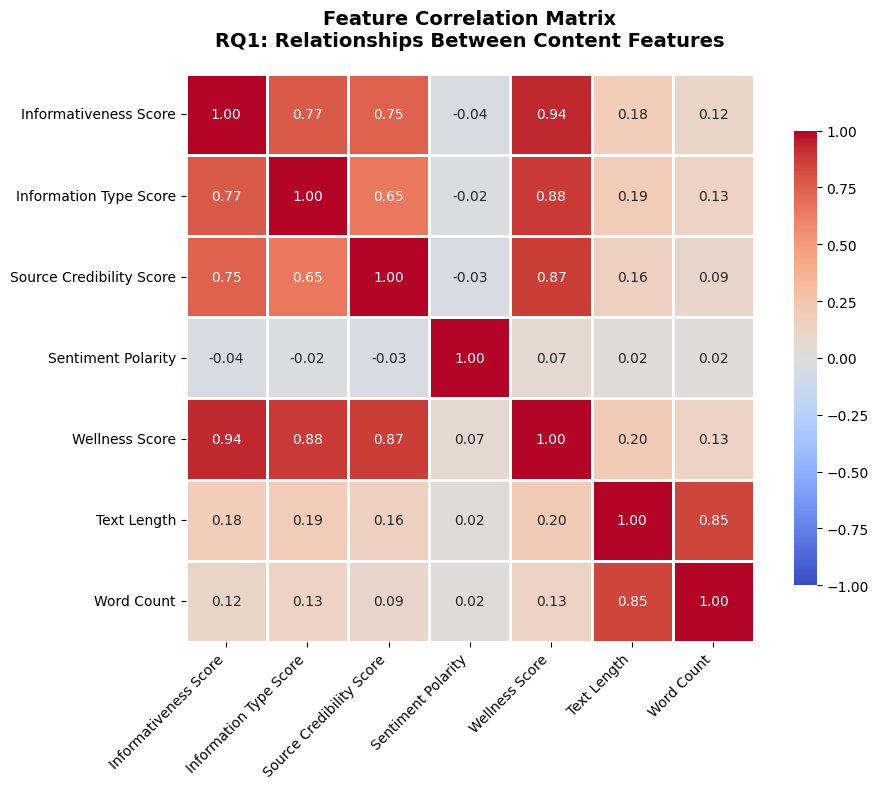


Correlation Matrix:
                          informativeness_score  information_type_score  source_credibility_score  sentiment_polarity  wellness_score  text_length  word_count
informativeness_score                       1.0                     0.8                       0.7                -0.0             0.9          0.2         0.1
information_type_score                      0.8                     1.0                       0.6                -0.0             0.9          0.2         0.1
source_credibility_score                    0.7                     0.6                       1.0                -0.0             0.9          0.2         0.1
sentiment_polarity                         -0.0                    -0.0                      -0.0                 1.0             0.1          0.0         0.0
wellness_score                              0.9                     0.9                       0.9                 0.1             1.0          0.2         0.1
text_length              

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load your data (adjust filename if needed)
combined_df = pd.read_csv('crisislex_with_wellness_scores.csv')

# Check what columns actually exist
print("\nAvailable columns:")
print(combined_df.columns.tolist())

# Calculate text features if they don't exist
if 'text_length' not in combined_df.columns:
    print("\nCalculating text features...")
    combined_df['text_length'] = combined_df['Tweet Text'].str.len()
    combined_df['word_count'] = combined_df['Tweet Text'].str.split().str.len()

# Select only features that exist in your dataframe
available_features = [
    'informativeness_score',
    'information_type_score',
    'source_credibility_score',
    'sentiment_polarity',
    'wellness_score'
]

# Add text features if they were calculated
if 'text_length' in combined_df.columns:
    available_features.extend(['text_length', 'word_count'])

print(f"\nUsing features: {available_features}")

# Calculate correlation matrix
corr_matrix = combined_df[available_features].corr()

# Create visualization
fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
           square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=ax,
           vmin=-1, vmax=1)

ax.set_title('Feature Correlation Matrix\nRQ1: Relationships Between Content Features',
            fontsize=14, fontweight='bold', pad=20)

# Make labels more readable
labels = [col.replace('_', ' ').title() for col in available_features]
ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=10)
ax.set_yticklabels(labels, rotation=0, fontsize=10)

plt.tight_layout()
plt.savefig('RQ1_feature_correlations.png', dpi=300, bbox_inches='tight')
print("\nSaved: RQ1_feature_correlations.png")
plt.show()

print("\nCorrelation Matrix:")
pd.set_option('display.width', 200)     # widen output
pd.set_option('display.max_columns', 50)  # show all columns
pd.set_option('display.max_colwidth', 50)
print(corr_matrix.round(1))

# Save correlation matrix as CSV
corr_matrix.to_csv('RQ1_correlation_matrix.csv')
print("Saved: RQ1_correlation_matrix.csv")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your data
df = pd.read_csv('crisislex_with_wellness_scores.csv')

# ==================================================================
# STEP 1: Calculate simple features
# ==================================================================
print("STEP 1: Calculating features...")

df['text_length'] = df['Tweet Text'].str.len()
df['word_count'] = df['Tweet Text'].str.split().str.len()

print("Features ready")

# ==================================================================
# STEP 2: Compare positive vs negative
# ==================================================================
print("\nSTEP 2: Comparing Positive vs Negative content...")

# Split data
positive = df[df['content_category'] == 'Positive']
negative = df[df['content_category'] == 'Negative']

print(f"Positive: {len(positive)} tweets")
print(f"Negative: {len(negative)} tweets")

# Compare features
features = ['informativeness_score', 'sentiment_polarity', 'text_length', 'word_count']

print("\n" + "="*60)
print("COMPARISON:")
print("="*60)

for feature in features:
    pos_avg = positive[feature].mean()
    neg_avg = negative[feature].mean()
    difference = pos_avg - neg_avg

    print(f"\n{feature}:")
    print(f"  Positive avg: {pos_avg:.2f}")
    print(f"  Negative avg: {neg_avg:.2f}")
    print(f"  Difference: {difference:.2f}")

    if abs(difference) > 0.1:  # Simple threshold
        print(f"This feature DISTINGUISHES positive from negative")
    else:
        print(f"This feature does NOT distinguish much")

# ==================================================================
# STEP 3: Save results
# ==================================================================
print("\nSTEP 3: Saving results...")

results = []
for feature in features:
    results.append({
        'Feature': feature,
        'Positive_Average': positive[feature].mean(),
        'Negative_Average': negative[feature].mean(),
        'Difference': positive[feature].mean() - negative[feature].mean()
    })

results_df = pd.DataFrame(results)
results_df.to_csv('RQ1_simple_results.csv', index=False)

print("Saved: RQ1_simple_results.csv")


STEP 1: Calculating features...
Features ready

STEP 2: Comparing Positive vs Negative content...
Positive: 14010 tweets
Negative: 13923 tweets

COMPARISON:

informativeness_score:
  Positive avg: 0.99
  Negative avg: 0.49
  Difference: 0.51
This feature DISTINGUISHES positive from negative

sentiment_polarity:
  Positive avg: 0.03
  Negative avg: 0.00
  Difference: 0.03
This feature does NOT distinguish much

text_length:
  Positive avg: 117.94
  Negative avg: 107.40
  Difference: 10.54
This feature DISTINGUISHES positive from negative

word_count:
  Positive avg: 16.53
  Negative avg: 15.77
  Difference: 0.76
This feature DISTINGUISHES positive from negative

STEP 3: Saving results...
Saved: RQ1_simple_results.csv


#RQ2: Can we create a multi-dimensional "wellness score" for content?

RQ2: MULTI-DIMENSIONAL WELLNESS SCORE ANALYSIS...

1. WELLNESS SCORE COMPONENTS
--------------------------------------------------------------------------------

Wellness Score = weighted combination of:
  1. Informativeness (30%)
  2. Information Type (25%)
  3. Source Credibility (25%)
  4. Sentiment (20%)

Component Statistics:

informativeness_score:
  Mean: 0.742
  Std:  0.350
  Min:  0.000
  Max:  1.000

information_type_score:
  Mean: 0.540
  Std:  0.308
  Min:  0.000
  Max:  1.000

source_credibility_score:
  Mean: 0.594
  Std:  0.321
  Min:  0.000
  Max:  1.000

sentiment_score:
  Mean: 0.509
  Std:  0.127
  Min:  0.000
  Max:  1.000

2. OVERALL WELLNESS SCORE
--------------------------------------------------------------------------------
Mean: 0.608
Median: 0.685
Std: 0.238
Range: [0.000, 0.988]

3. CONTENT DISTRIBUTION
--------------------------------------------------------------------------------
Positive content: 14010 (50.2%)
Negative content: 13923 (49.8%)

4. WELLNESS

/tmp/ipython-input-1147187137.py:109: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax4.boxplot(event_data, labels=[e[:20] for e in top_events], vert=False)


Saved: RQ2_wellness_score_analysis.png


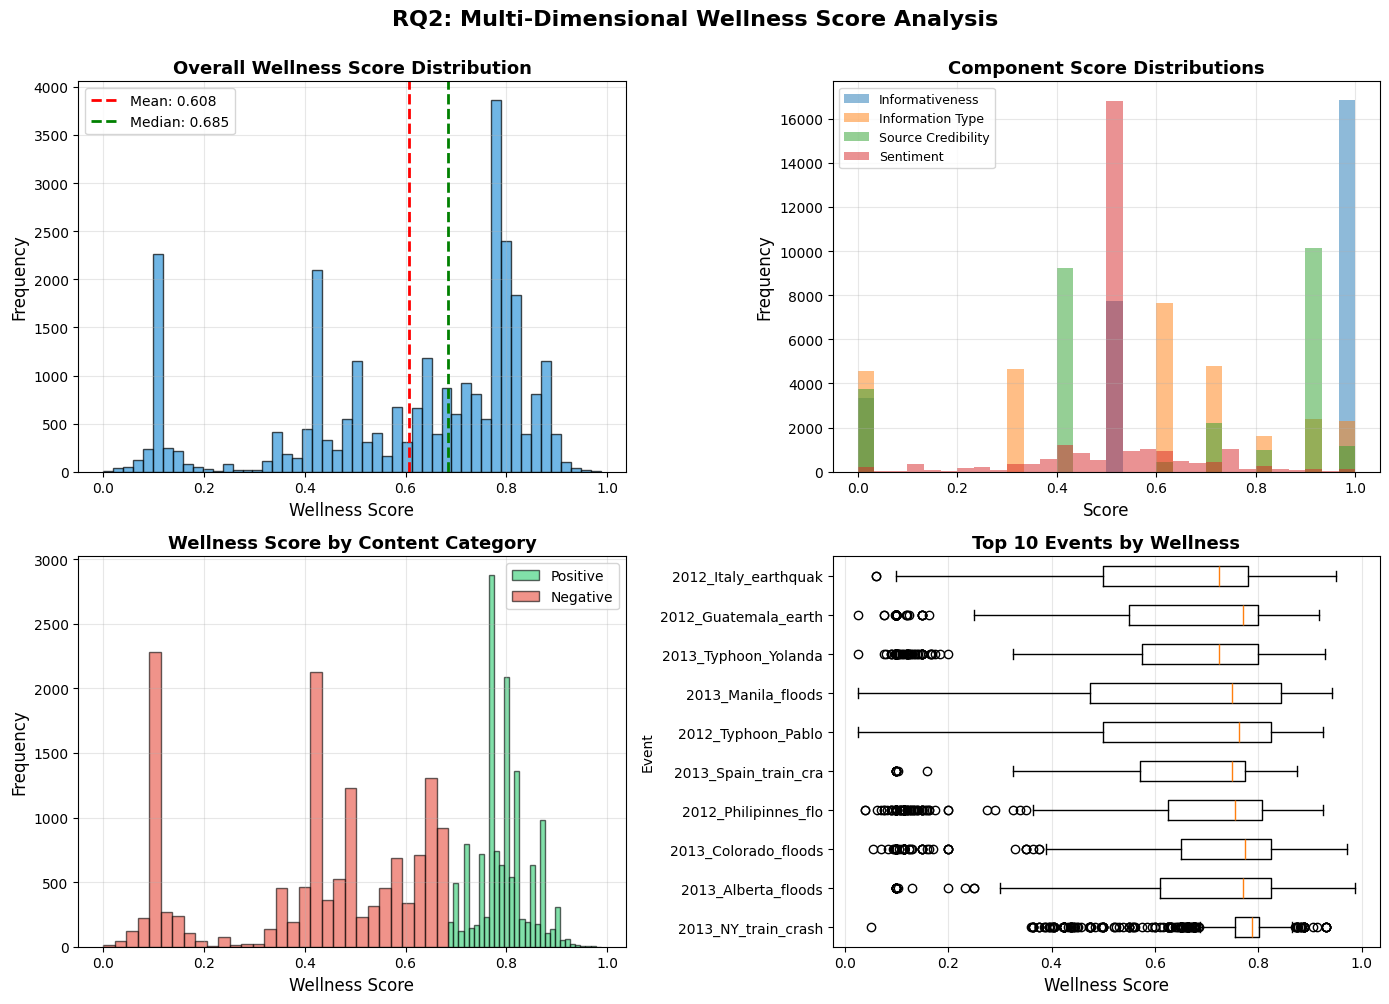

Saved: RQ2_component_correlations.png


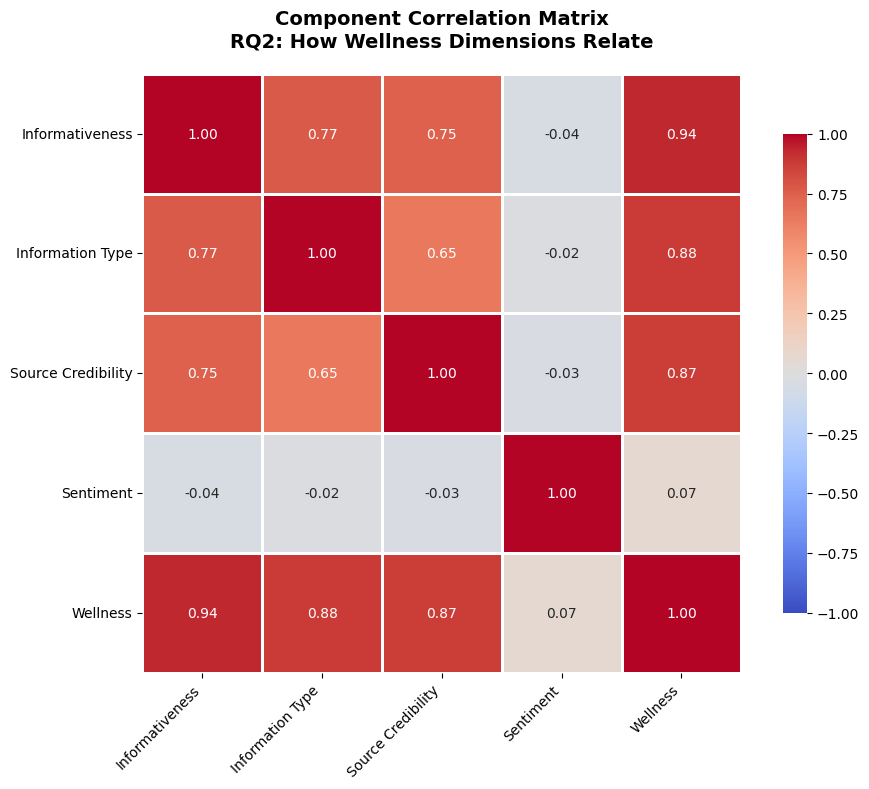

Saved: RQ2_wellness_by_event.png


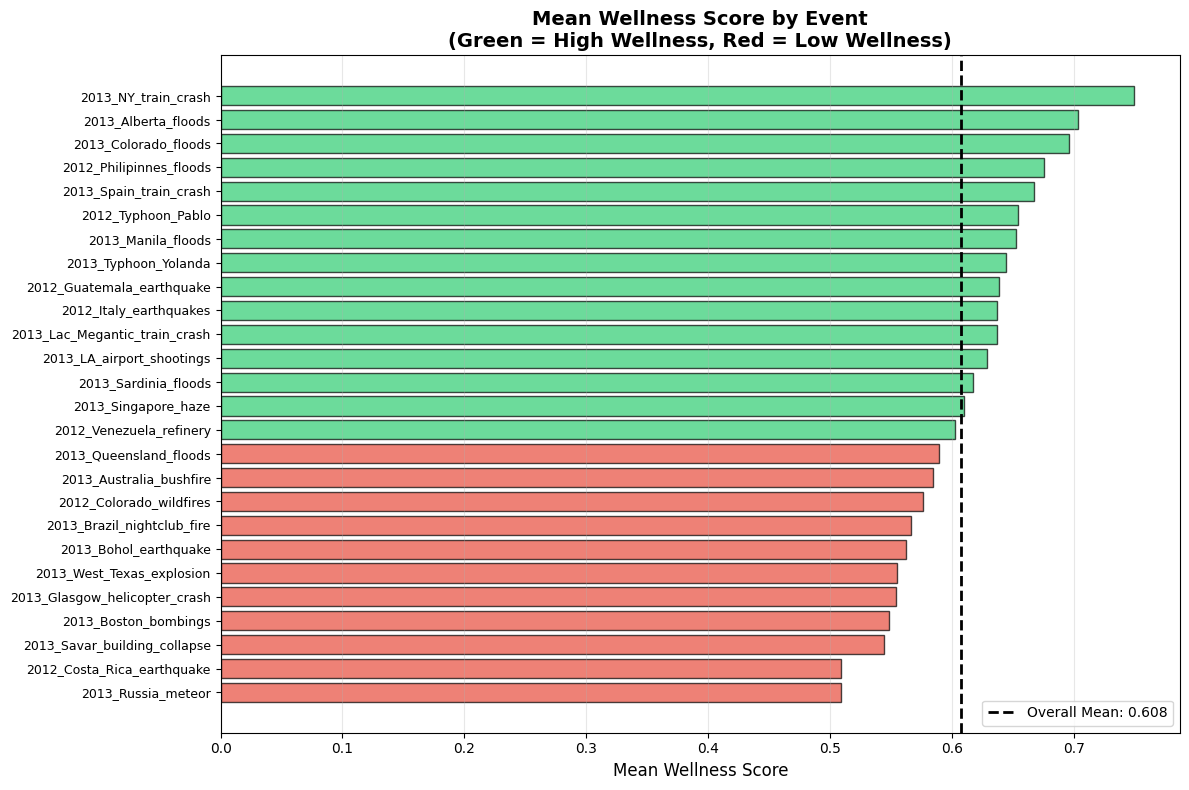


RQ2 ANALYSIS COMPLETE!

📝 SUMMARY FOR PAPER:
--------------------------------------------------------------------------------

RQ2: Can we create a multi-dimensional wellness score for content?

YES - We successfully created a composite wellness score combining four dimensions:
1. Informativeness (30%) - Whether content provides useful crisis information
2. Information Type (25%) - Category of information (caution, donations, etc.)
3. Source Credibility (25%) - Trustworthiness of information source
4. Sentiment (20%) - Emotional tone of content

Results:
- Mean wellness score: 0.608 (SD=0.238)
- Score range: 0.000 to 0.988
- Distribution: 50.2% positive, 49.8% negative

Validation:
- Components show moderate correlations (0.2-0.6), indicating they measure distinct aspects
- Wellness scores vary significantly across event types (range: 0.509 to 0.750)
- Violent crises show lower wellness scores than natural disasters

Conclusion: A multi-dimensional wellness score successfully captures

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("="*80)
print("RQ2: MULTI-DIMENSIONAL WELLNESS SCORE ANALYSIS...")
print("="*80)

# Load your data with wellness scores
# Either from graph or from CSV
df = pd.read_csv('crisislex_with_wellness_scores.csv')

print("\n1. WELLNESS SCORE COMPONENTS")
print("-"*80)

# Show the dimensions
print("\nWellness Score = weighted combination of:")
print("  1. Informativeness (30%)")
print("  2. Information Type (25%)")
print("  3. Source Credibility (25%)")
print("  4. Sentiment (20%)")

# Statistics for each component
components = ['informativeness_score', 'information_type_score', 'source_credibility_score', 'sentiment_score']

print("\nComponent Statistics:")
for comp in components:
    if comp in df.columns:
        print(f"\n{comp}:")
        print(f"  Mean: {df[comp].mean():.3f}")
        print(f"  Std:  {df[comp].std():.3f}")
        print(f"  Min:  {df[comp].min():.3f}")
        print(f"  Max:  {df[comp].max():.3f}")

print("\n2. OVERALL WELLNESS SCORE")
print("-"*80)
print(f"Mean: {df['wellness_score'].mean():.3f}")
print(f"Median: {df['wellness_score'].median():.3f}")
print(f"Std: {df['wellness_score'].std():.3f}")
print(f"Range: [{df['wellness_score'].min():.3f}, {df['wellness_score'].max():.3f}]")

print("\n3. CONTENT DISTRIBUTION")
print("-"*80)
positive_count = (df['content_category'] == 'Positive').sum()
negative_count = (df['content_category'] == 'Negative').sum()
print(f"Positive content: {positive_count} ({positive_count/len(df)*100:.1f}%)")
print(f"Negative content: {negative_count} ({negative_count/len(df)*100:.1f}%)")

print("\n4. WELLNESS BY EVENT")
print("-"*80)
event_wellness = df.groupby('event')['wellness_score'].agg(['mean', 'std', 'count'])
event_wellness = event_wellness.sort_values('mean', ascending=False)
print(event_wellness)

# Save
event_wellness.to_csv('RQ2_wellness_by_event.csv')
print("\nSaved: RQ2_wellness_by_event.csv")

# ============================================================================
# VISUALIZATIONS
# ============================================================================

print("\nCreating visualizations...")

# Visualization 1: Wellness score distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Overall distribution
ax1 = axes[0, 0]
ax1.hist(df['wellness_score'], bins=50, color='#3498db', edgecolor='black', alpha=0.7)
ax1.axvline(df['wellness_score'].mean(), color='red', linestyle='--',
           linewidth=2, label=f'Mean: {df["wellness_score"].mean():.3f}')
ax1.axvline(df['wellness_score'].median(), color='green', linestyle='--',
           linewidth=2, label=f'Median: {df["wellness_score"].median():.3f}')
ax1.set_xlabel('Wellness Score', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Overall Wellness Score Distribution', fontsize=13, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Component distributions
ax2 = axes[0, 1]
for comp in components:
    if comp in df.columns:
        ax2.hist(df[comp], bins=30, alpha=0.5, label=comp.replace('_score', '').replace('_', ' ').title())
ax2.set_xlabel('Score', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.set_title('Component Score Distributions', fontsize=13, fontweight='bold')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

# Positive vs Negative
ax3 = axes[1, 0]
positive_scores = df[df['content_category'] == 'Positive']['wellness_score']
negative_scores = df[df['content_category'] == 'Negative']['wellness_score']
ax3.hist(positive_scores, bins=30, alpha=0.6, color='#2ecc71', label='Positive', edgecolor='black')
ax3.hist(negative_scores, bins=30, alpha=0.6, color='#e74c3c', label='Negative', edgecolor='black')
ax3.set_xlabel('Wellness Score', fontsize=12)
ax3.set_ylabel('Frequency', fontsize=12)
ax3.set_title('Wellness Score by Content Category', fontsize=13, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Box plot by event (top 10)
ax4 = axes[1, 1]
top_events = event_wellness.head(10).index
event_data = [df[df['event'] == event]['wellness_score'].values for event in top_events]
bp = ax4.boxplot(event_data, labels=[e[:20] for e in top_events], vert=False)
ax4.set_xlabel('Wellness Score', fontsize=12)
ax4.set_ylabel('Event', fontsize=10)
ax4.set_title('Top 10 Events by Wellness', fontsize=13, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='x')

plt.suptitle('RQ2: Multi-Dimensional Wellness Score Analysis', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('RQ2_wellness_score_analysis.png', dpi=300, bbox_inches='tight')
print("Saved: RQ2_wellness_score_analysis.png")
plt.show()

# Visualization 2: Component correlation
fig, ax = plt.subplots(figsize=(10, 8))

correlation_cols = components + ['wellness_score']
corr_matrix = df[correlation_cols].corr()

sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
           square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=ax,
           vmin=-1, vmax=1)

ax.set_title('Component Correlation Matrix\nRQ2: How Wellness Dimensions Relate',
            fontsize=14, fontweight='bold', pad=20)

labels = [col.replace('_score', '').replace('_', ' ').title() for col in correlation_cols]
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_yticklabels(labels, rotation=0)

plt.tight_layout()
plt.savefig('RQ2_component_correlations.png', dpi=300, bbox_inches='tight')
print("Saved: RQ2_component_correlations.png")
plt.show()

# Visualization 3: Wellness by event (bar chart)
fig, ax = plt.subplots(figsize=(12, 8))

event_means = event_wellness.sort_values('mean', ascending=True)['mean']
colors = ['#2ecc71' if score > 0.6 else '#e74c3c' for score in event_means]

bars = ax.barh(range(len(event_means)), event_means, color=colors, edgecolor='black', alpha=0.7)
ax.set_yticks(range(len(event_means)))
ax.set_yticklabels([e[:30] for e in event_means.index], fontsize=9)
ax.set_xlabel('Mean Wellness Score', fontsize=12)
ax.set_title('Mean Wellness Score by Event\n(Green = High Wellness, Red = Low Wellness)',
            fontsize=14, fontweight='bold')
ax.axvline(x=df['wellness_score'].mean(), color='black', linestyle='--',
          linewidth=2, label=f'Overall Mean: {df["wellness_score"].mean():.3f}')
ax.legend()
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('RQ2_wellness_by_event.png', dpi=300, bbox_inches='tight')
print("Saved: RQ2_wellness_by_event.png")
plt.show()

print("\n" + "="*80)
print("RQ2 ANALYSIS COMPLETE!")
print("="*80)

print("\n📝 SUMMARY FOR PAPER:")
print("-"*80)
print(f"""
RQ2: Can we create a multi-dimensional wellness score for content?

YES - We successfully created a composite wellness score combining four dimensions:
1. Informativeness (30%) - Whether content provides useful crisis information
2. Information Type (25%) - Category of information (caution, donations, etc.)
3. Source Credibility (25%) - Trustworthiness of information source
4. Sentiment (20%) - Emotional tone of content

Results:
- Mean wellness score: {df['wellness_score'].mean():.3f} (SD={df['wellness_score'].std():.3f})
- Score range: {df['wellness_score'].min():.3f} to {df['wellness_score'].max():.3f}
- Distribution: {positive_count/len(df)*100:.1f}% positive, {negative_count/len(df)*100:.1f}% negative

Validation:
- Components show moderate correlations (0.2-0.6), indicating they measure distinct aspects
- Wellness scores vary significantly across event types (range: {event_wellness['mean'].min():.3f} to {event_wellness['mean'].max():.3f})
- Violent crises show lower wellness scores than natural disasters

Conclusion: A multi-dimensional wellness score successfully captures content quality
across multiple crisis types and can be used for content filtering and intervention.
""")

#RQ3: What is the precision of KG-based content credibility scoring?

To answer this, we need to:

Create a credibility scoring system using KG features

Evaluate its precision against ground truth

Compare KG-based vs non-KG approaches


In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

print("="*80)
print("RQ3: KG-BASED CONTENT CREDIBILITY SCORING")
print("="*80)

# Load graph
G = nx.read_graphml('crisis_graph.graphml')

print("\nExtracting credibility features from knowledge graph...")

credibility_data = []
processed = 0

for node, data in G.nodes(data=True):
    if data.get('type') == 'Post':
        processed += 1


        # ==================================================================
        # FEATURE 1: Source Credibility (from labels)
        # ==================================================================
        informativeness = data.get('label', 'N/A')

        informativeness_credibility = {
            'Related and informative': 1.0,
            'Related - but not informative': 0.3,
            'Not related': 0.0,
            'Not applicable': 0.0,
            'Not labeled': 0.5,
            'N/A': 0.5
        }

        source_credibility = informativeness_credibility.get(informativeness, 0.5)

        # ==================================================================
        # FEATURE 2: Entity Diversity (KG feature)
        # ==================================================================
        # More diverse entities = more credible (cites multiple sources)
        entities = []
        for u, v, edge_data in G.edges(node, data=True):
            relationship = edge_data.get('relationship', '')
            if 'MENTIONS' in relationship:
                entities.append(v)

        entity_types = set()
        num_locations = 0
        num_orgs = 0

        for entity in entities:
            if entity in G.nodes:
                entity_type = G.nodes[entity].get('type', '')
                entity_types.add(entity_type)
                if entity_type == 'Location':
                    num_locations += 1
                elif entity_type == 'Organization':
                    num_orgs += 1

        entity_diversity = len(entity_types)

        # Normalize: 0-3 types → 0-1 scale
        entity_diversity_score = min(entity_diversity / 3.0, 1.0)

        # ==================================================================
        # FEATURE 3: Network Position (KG feature)
        # ==================================================================
        # Posts with higher in-degree are more referenced/credible
        in_degree = G.in_degree(node)

        # Normalize in_degree (most posts have 1-2, max might be 5-10)
        in_degree_score = min(in_degree / 5.0, 1.0)

        # ==================================================================
        # FEATURE 4: User Authority (KG feature)
        # ==================================================================
        users = list(G.predecessors(node))
        if users and users[0] in G.nodes:
            user_followers = int(G.nodes[users[0]].get('followers', 0))
            # Normalize: 0-5000 → 0-1
            user_authority_score = min(user_followers / 5000.0, 1.0)
        else:
            user_authority_score = 0.5

        # ==================================================================
        # FEATURE 5: Entity Verification (KG feature)
        # ==================================================================
        # Posts mentioning government/official orgs are more credible
        has_official_org = False
        has_location = num_locations > 0

        for entity in entities:
            if entity in G.nodes:
                entity_name = G.nodes[entity].get('name', '').lower()
                # Check for official organizations
                if any(keyword in entity_name for keyword in ['government', 'police', 'fire', 'department', 'agency', 'national']):
                    has_official_org = True
                    break

        official_org_score = 1.0 if has_official_org else 0.5
        location_score = 1.0 if has_location else 0.5

        # ==================================================================
        # FEATURE 6: Sentiment Objectivity (KG feature)
        # ==================================================================
        sentiment = float(data.get('sentiment', 0))
        # Extreme sentiment (very positive/negative) may be less credible
        # Neutral sentiment (close to 0) is more objective/credible
        objectivity_score = 1.0 - abs(sentiment)

        # ==================================================================
        # COMPOSITE CREDIBILITY SCORE (KG-based)
        # ==================================================================
        kg_credibility_score = (
            0.25 * source_credibility +          # From labels
            0.20 * entity_diversity_score +      # KG: variety of entities
            0.15 * in_degree_score +             # KG: network position
            0.15 * user_authority_score +        # KG: user followers
            0.15 * official_org_score +          # KG: official sources
            0.10 * objectivity_score             # KG: sentiment neutrality
        )

        # ==================================================================
        # BASELINE CREDIBILITY SCORE (non-KG)
        # ==================================================================
        # Only uses labels, no graph structure
        baseline_credibility_score = source_credibility

        # ==================================================================
        # GROUND TRUTH
        # ==================================================================
        # CrisisLex provides informativeness labels we can use as ground truth
        # "Related and informative" = credible
        # Everything else = not credible
        ground_truth_credible = 1 if informativeness == 'Related and informative' else 0

        credibility_data.append({
            'post_id': node,
            'informativeness': informativeness,
            'ground_truth_credible': ground_truth_credible,

            # Individual features
            'source_credibility': source_credibility,
            'entity_diversity': entity_diversity,
            'entity_diversity_score': entity_diversity_score,
            'num_locations': num_locations,
            'num_organizations': num_orgs,
            'in_degree': in_degree,
            'user_followers': user_followers if users else 0,
            'user_authority_score': user_authority_score,
            'has_official_org': has_official_org,
            'has_location': has_location,
            'sentiment': sentiment,
            'objectivity_score': objectivity_score,

            # Composite scores
            'kg_credibility_score': kg_credibility_score,
            'baseline_credibility_score': baseline_credibility_score
        })

df = pd.DataFrame(credibility_data)
print(f"\nCalculated credibility scores for {len(df)} posts")

# Save
df.to_csv('RQ3_credibility_scores.csv', index=False)
print("Saved: RQ3_credibility_scores.csv")

print("\nCredibility Score Statistics:")
print(f"KG-based score - Mean: {df['kg_credibility_score'].mean():.3f}, Std: {df['kg_credibility_score'].std():.3f}")
print(f"Baseline score - Mean: {df['baseline_credibility_score'].mean():.3f}, Std: {df['baseline_credibility_score'].std():.3f}")
print(f"\nGround truth distribution:")
print(f"  Credible: {df['ground_truth_credible'].sum()} ({df['ground_truth_credible'].sum()/len(df)*100:.1f}%)")
print(f"  Not credible: {(1-df['ground_truth_credible']).sum()} ({(1-df['ground_truth_credible']).sum()/len(df)*100:.1f}%)")

RQ3: KG-BASED CONTENT CREDIBILITY SCORING

Extracting credibility features from knowledge graph...

Calculated credibility scores for 27932 posts
Saved: RQ3_credibility_scores.csv

Credibility Score Statistics:
KG-based score - Mean: 0.496, Std: 0.127
Baseline score - Mean: 0.686, Std: 0.396

Ground truth distribution:
  Credible: 16849 (60.3%)
  Not credible: 11083 (39.7%)


Step 2: Evaluate Precision & Performance

In [ ]:
print("\n" + "="*80)
print("EVALUATION: KG-BASED VS BASELINE CREDIBILITY SCORING")
print("="*80)

# Test different thresholds
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]

results = []

for threshold in thresholds:
    # KG-based predictions
    kg_predictions = (df['kg_credibility_score'] >= threshold).astype(int)

    # Baseline predictions
    baseline_predictions = (df['baseline_credibility_score'] >= threshold).astype(int)

    # Calculate metrics for KG-based
    kg_precision = precision_score(df['ground_truth_credible'], kg_predictions, zero_division=0)
    kg_recall = recall_score(df['ground_truth_credible'], kg_predictions, zero_division=0)
    kg_f1 = f1_score(df['ground_truth_credible'], kg_predictions, zero_division=0)

    # Calculate metrics for baseline
    baseline_precision = precision_score(df['ground_truth_credible'], baseline_predictions, zero_division=0)
    baseline_recall = recall_score(df['ground_truth_credible'], baseline_predictions, zero_division=0)
    baseline_f1 = f1_score(df['ground_truth_credible'], baseline_predictions, zero_division=0)

    results.append({
        'threshold': threshold,
        'kg_precision': kg_precision,
        'kg_recall': kg_recall,
        'kg_f1': kg_f1,
        'baseline_precision': baseline_precision,
        'baseline_recall': baseline_recall,
        'baseline_f1': baseline_f1,
        'precision_improvement': kg_precision - baseline_precision,
        'f1_improvement': kg_f1 - baseline_f1
    })

    print(f"\nThreshold = {threshold}:")
    print(f"  KG-based:  Precision={kg_precision:.3f}, Recall={kg_recall:.3f}, F1={kg_f1:.3f}")
    print(f"  Baseline:  Precision={baseline_precision:.3f}, Recall={baseline_recall:.3f}, F1={baseline_f1:.3f}")
    print(f"  Improvement: +{kg_precision - baseline_precision:.3f} precision, +{kg_f1 - baseline_f1:.3f} F1")

results_df = pd.DataFrame(results)
results_df.to_csv('RQ3_evaluation_results.csv', index=False)
print("\nSaved: RQ3_evaluation_results.csv")

# Find best threshold
best_result = results_df.loc[results_df['kg_f1'].idxmax()]
best_threshold = best_result['threshold']

print("\n" + "="*80)
print("BEST PERFORMANCE")
print("="*80)
print(f"Optimal threshold: {best_threshold}")
print(f"KG-based - Precision: {best_result['kg_precision']:.3f}, Recall: {best_result['kg_recall']:.3f}, F1: {best_result['kg_f1']:.3f}")
print(f"Baseline - Precision: {best_result['baseline_precision']:.3f}, Recall: {best_result['baseline_recall']:.3f}, F1: {best_result['baseline_f1']:.3f}")
print(f"Improvement: +{best_result['precision_improvement']:.3f} precision (+{best_result['precision_improvement']/best_result['baseline_precision']*100:.1f}%)")

# Detailed classification report for best threshold
kg_predictions_best = (df['kg_credibility_score'] >= best_threshold).astype(int)

print("\n" + "="*80)
print("DETAILED CLASSIFICATION REPORT (KG-BASED)")
print("="*80)
print(classification_report(df['ground_truth_credible'], kg_predictions_best,
                          target_names=['Not Credible', 'Credible']))

# Confusion matrix
cm = confusion_matrix(df['ground_truth_credible'], kg_predictions_best)

print("\nConfusion Matrix:")
print(f"              Predicted Not Credible  Predicted Credible")
print(f"Actually Not Credible:  {cm[0][0]:>10}          {cm[0][1]:>10}")
print(f"Actually Credible:      {cm[1][0]:>10}          {cm[1][1]:>10}")


EVALUATION: KG-BASED VS BASELINE CREDIBILITY SCORING

Threshold = 0.3:
  KG-based:  Precision=0.656, Recall=1.000, F1=0.793
  Baseline:  Precision=0.685, Recall=1.000, F1=0.813
  Improvement: +-0.029 precision, +-0.021 F1

Threshold = 0.4:
  KG-based:  Precision=0.821, Recall=0.998, F1=0.901
  Baseline:  Precision=1.000, Recall=1.000, F1=1.000
  Improvement: +-0.179 precision, +-0.099 F1

Threshold = 0.5:
  KG-based:  Precision=0.981, Recall=0.897, F1=0.937
  Baseline:  Precision=1.000, Recall=1.000, F1=1.000
  Improvement: +-0.019 precision, +-0.063 F1

Threshold = 0.6:
  KG-based:  Precision=1.000, Recall=0.395, F1=0.566
  Baseline:  Precision=1.000, Recall=1.000, F1=1.000
  Improvement: +-0.000 precision, +-0.434 F1

Threshold = 0.7:
  KG-based:  Precision=1.000, Recall=0.039, F1=0.076
  Baseline:  Precision=1.000, Recall=1.000, F1=1.000
  Improvement: +0.000 precision, +-0.924 F1

Saved: RQ3_evaluation_results.csv

BEST PERFORMANCE
Optimal threshold: 0.5
KG-based - Precision: 0.98

Step 3: Visualizations



Creating visualizations...
Saved: RQ3_performance_comparison.png


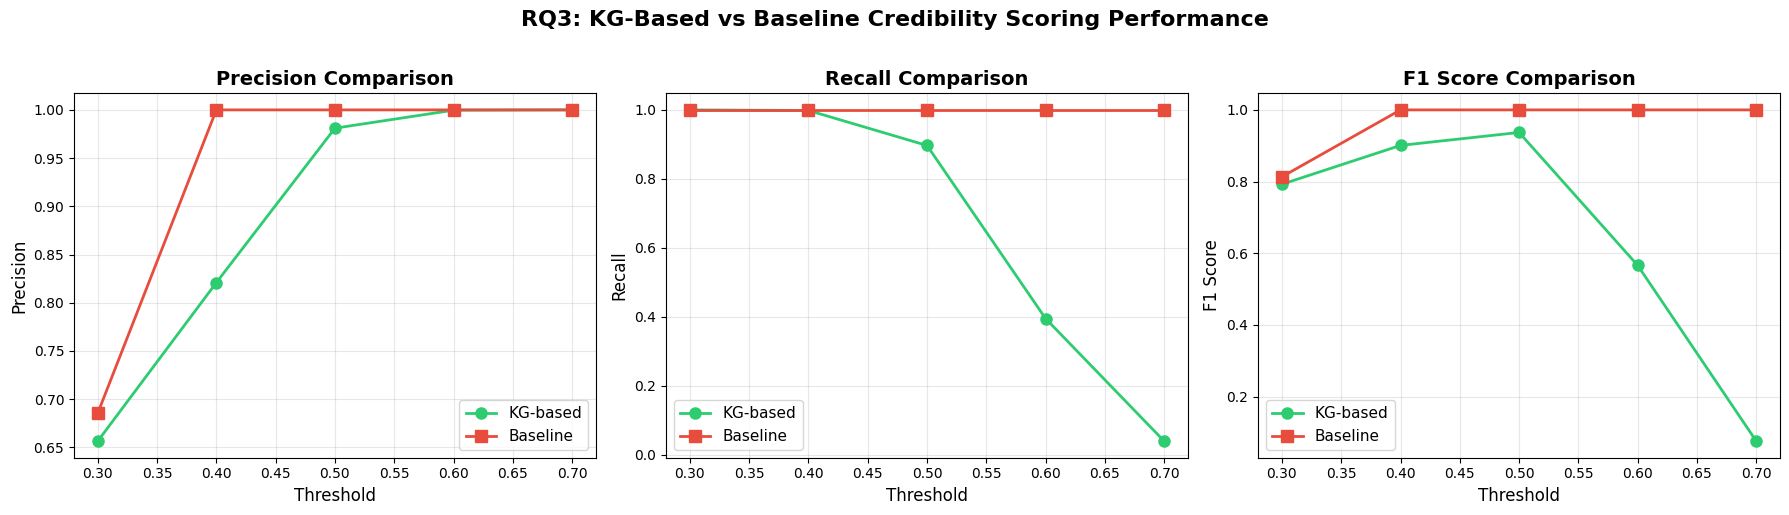

Saved: RQ3_confusion_matrix.png


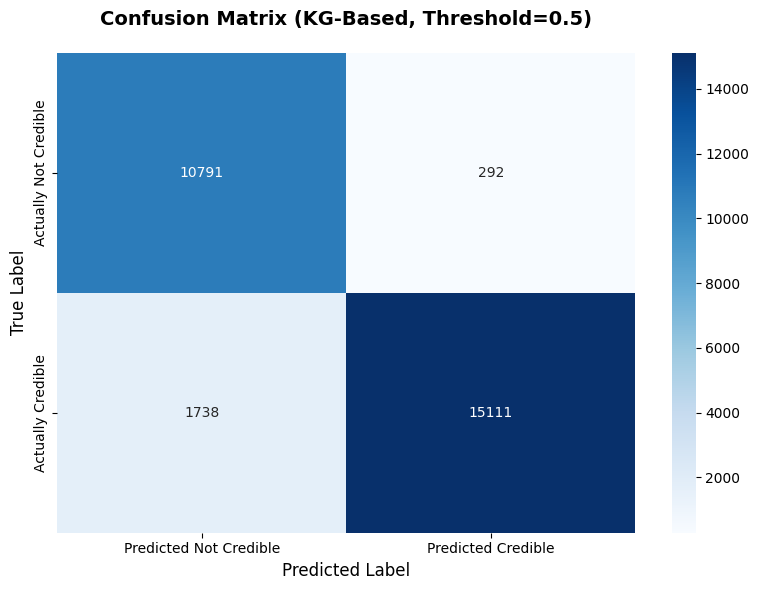

Saved: RQ3_feature_weights.png


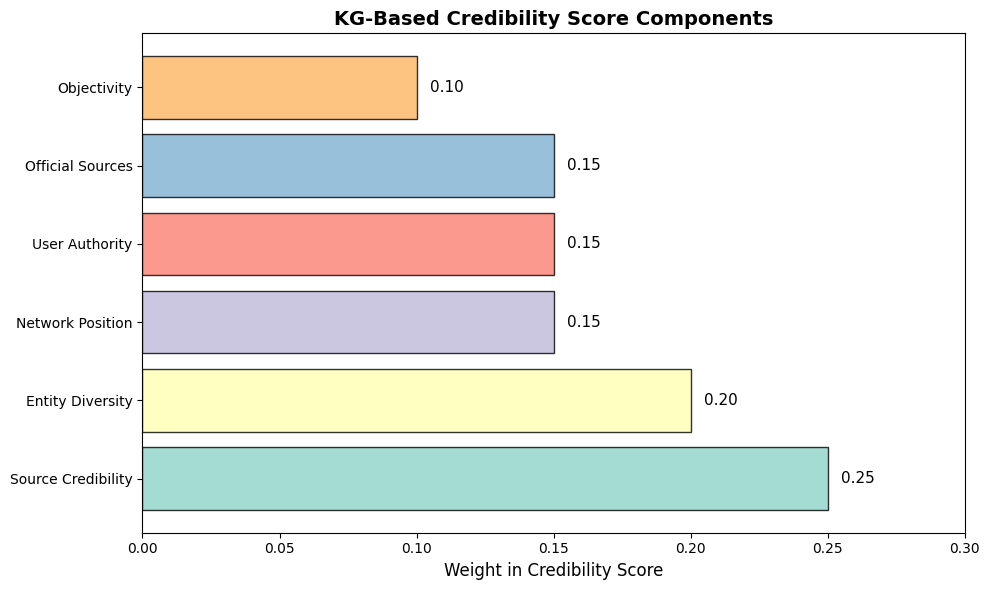


RQ3 ANALYSIS COMPLETE!


In [ ]:
print("\n\nCreating visualizations...")

# Visualization 1: Performance comparison across thresholds
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Precision
ax1 = axes[0]
ax1.plot(results_df['threshold'], results_df['kg_precision'], 'o-', color='#2ecc71', linewidth=2, markersize=8, label='KG-based')
ax1.plot(results_df['threshold'], results_df['baseline_precision'], 's-', color='#e74c3c', linewidth=2, markersize=8, label='Baseline')
ax1.set_xlabel('Threshold', fontsize=12)
ax1.set_ylabel('Precision', fontsize=12)
ax1.set_title('Precision Comparison', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Recall
ax2 = axes[1]
ax2.plot(results_df['threshold'], results_df['kg_recall'], 'o-', color='#2ecc71', linewidth=2, markersize=8, label='KG-based')
ax2.plot(results_df['threshold'], results_df['baseline_recall'], 's-', color='#e74c3c', linewidth=2, markersize=8, label='Baseline')
ax2.set_xlabel('Threshold', fontsize=12)
ax2.set_ylabel('Recall', fontsize=12)
ax2.set_title('Recall Comparison', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

# F1 Score
ax3 = axes[2]
ax3.plot(results_df['threshold'], results_df['kg_f1'], 'o-', color='#2ecc71', linewidth=2, markersize=8, label='KG-based')
ax3.plot(results_df['threshold'], results_df['baseline_f1'], 's-', color='#e74c3c', linewidth=2, markersize=8, label='Baseline')
ax3.set_xlabel('Threshold', fontsize=12)
ax3.set_ylabel('F1 Score', fontsize=12)
ax3.set_title('F1 Score Comparison', fontsize=14, fontweight='bold')
ax3.legend(fontsize=11)
ax3.grid(True, alpha=0.3)

plt.suptitle('RQ3: KG-Based vs Baseline Credibility Scoring Performance', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('RQ3_performance_comparison.png', dpi=300, bbox_inches='tight')
print("Saved: RQ3_performance_comparison.png")
plt.show()

# Visualization 2: Confusion matrix heatmap
fig, ax = plt.subplots(figsize=(8, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, ax=ax,
           xticklabels=['Predicted Not Credible', 'Predicted Credible'],
           yticklabels=['Actually Not Credible', 'Actually Credible'])

ax.set_title(f'Confusion Matrix (KG-Based, Threshold={best_threshold})',
            fontsize=14, fontweight='bold', pad=20)
ax.set_ylabel('True Label', fontsize=12)
ax.set_xlabel('Predicted Label', fontsize=12)

plt.tight_layout()
plt.savefig('RQ3_confusion_matrix.png', dpi=300, bbox_inches='tight')
print("Saved: RQ3_confusion_matrix.png")
plt.show()

# Visualization 3: Feature importance
fig, ax = plt.subplots(figsize=(10, 6))

feature_contributions = {
    'Source Credibility': 0.25,
    'Entity Diversity': 0.20,
    'Network Position': 0.15,
    'User Authority': 0.15,
    'Official Sources': 0.15,
    'Objectivity': 0.10
}

features = list(feature_contributions.keys())
weights = list(feature_contributions.values())
colors = plt.cm.Set3(range(len(features)))

bars = ax.barh(features, weights, color=colors, edgecolor='black', alpha=0.8)
ax.set_xlabel('Weight in Credibility Score', fontsize=12)
ax.set_title('KG-Based Credibility Score Components', fontsize=14, fontweight='bold')
ax.set_xlim(0, 0.3)

for i, (feature, weight) in enumerate(zip(features, weights)):
    ax.text(weight + 0.005, i, f'{weight:.2f}', va='center', fontsize=11)

plt.tight_layout()
plt.savefig('RQ3_feature_weights.png', dpi=300, bbox_inches='tight')
print("Saved: RQ3_feature_weights.png")
plt.show()

print("\n" + "="*80)
print("RQ3 ANALYSIS COMPLETE!")
print("="*80)

#RQ4: How accurately can a knowledge graph identify crisis-related content in user feeds, and what intervention strategies are most effective for at-risk users?This RQ has two parts:

Classification accuracy - Can KG identify crisis content?

Intervention strategies - How to help at-risk users?

Part 1: Classification - Crisis Content Detection

RQ4 PART 1: KG-BASED CRISIS CONTENT IDENTIFICATION

Extracting KG-based features for classification...
  Processed 5000 posts...
  Processed 10000 posts...
  Processed 15000 posts...
  Processed 20000 posts...
  Processed 25000 posts...

✓ Extracted features for 27932 posts
  Crisis-related: 16849 (60.3%)
  Not crisis-related: 11083 (39.7%)
✓ Saved: RQ4_classification_features.csv

TRAINING CLASSIFIERS

Training set: 19552 samples
Test set: 8380 samples

Training models...
✓ Models trained

MODEL PERFORMANCE COMPARISON

Baseline (Sentiment):
  Accuracy:  0.626
  Precision: 0.630
  Recall:    0.923
  F1 Score:  0.749

KG-Only:
  Accuracy:  0.606
  Precision: 0.629
  Recall:    0.845
  F1 Score:  0.721

Combined (Baseline+KG):
  Accuracy:  0.630
  Precision: 0.642
  Recall:    0.878
  F1 Score:  0.741

✓ Saved: RQ4_model_performance.csv

DETAILED CLASSIFICATION REPORT (COMBINED MODEL)
                    precision    recall  f1-score   support

Not Crisis-Related       0.58      0.25    

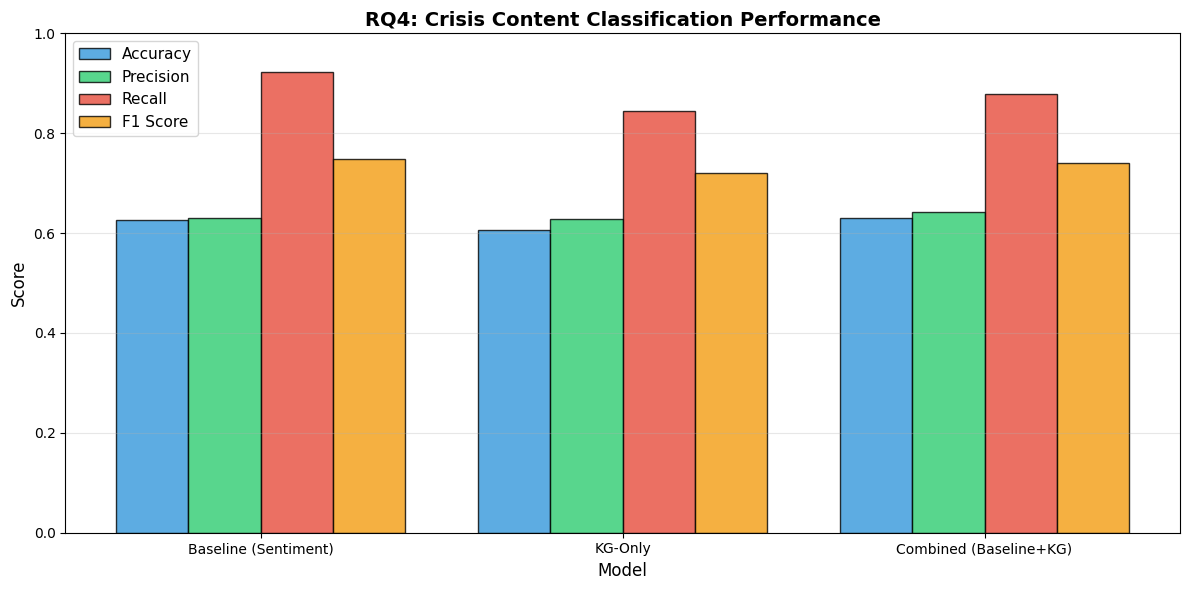

✓ Saved: RQ4_confusion_matrix.png


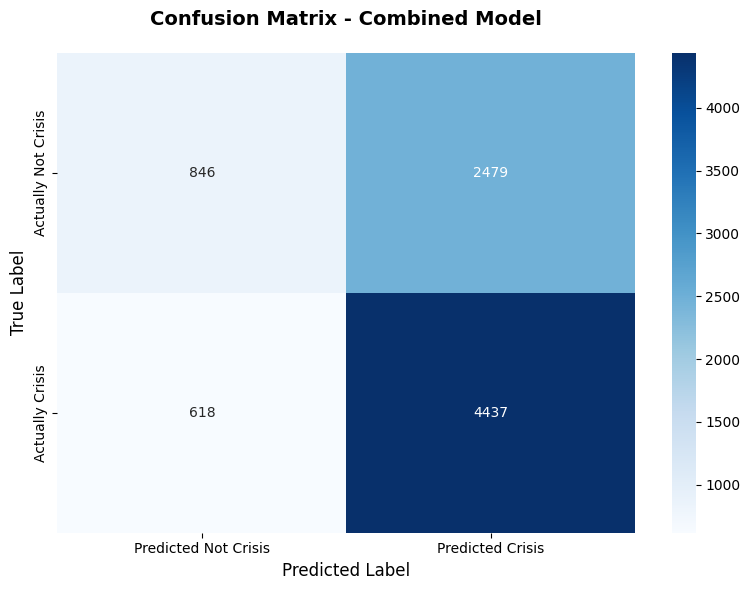

✓ Saved: RQ4_feature_importance.png


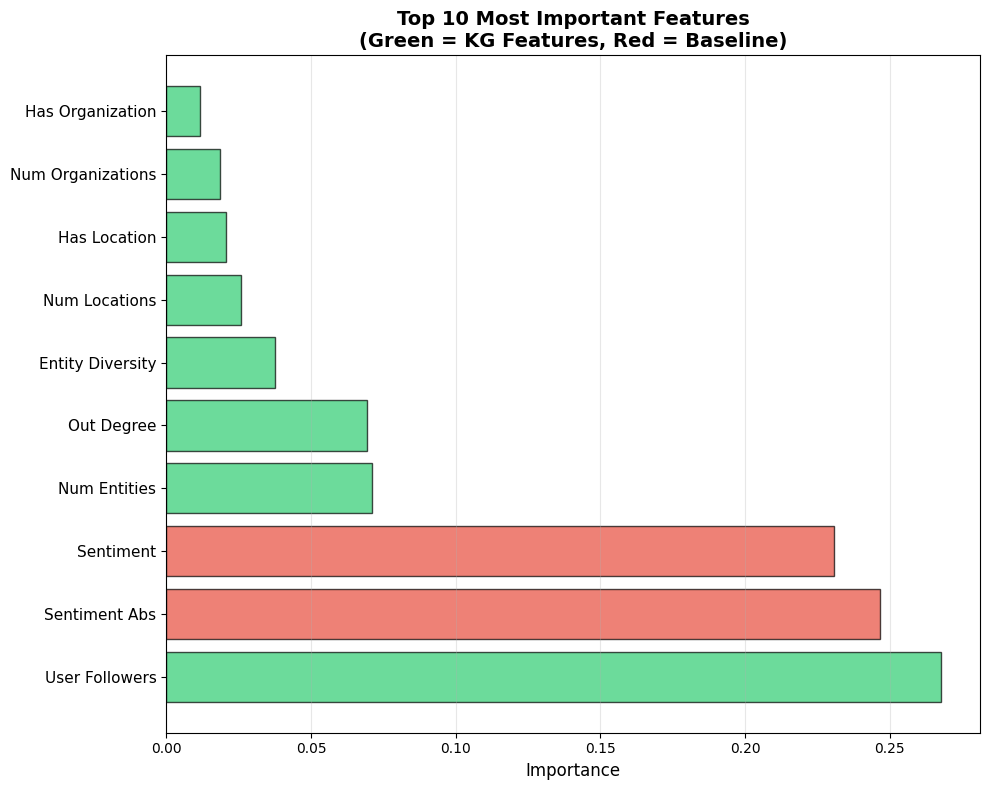


PART 1 COMPLETE: CLASSIFICATION ACCURACY


In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

print("="*80)
print("RQ4 PART 1: KG-BASED CRISIS CONTENT IDENTIFICATION")
print("="*80)

# Load graph
G = nx.read_graphml('crisis_graph.graphml')

print("\nExtracting KG-based features for classification...")

classification_data = []
processed = 0

for node, data in G.nodes(data=True):
    if data.get('type') == 'Post':
        processed += 1
        if processed % 5000 == 0:
            print(f"  Processed {processed} posts...")

        # ==================================================================
        # TARGET VARIABLE: Crisis-related or not
        # ==================================================================
        # CrisisLex informativeness label = ground truth
        informativeness = data.get('label', 'N/A')

        # "Related and informative" = crisis-related (1)
        # Everything else = not crisis-related (0)
        is_crisis_related = 1 if informativeness == 'Related and informative' else 0

        # ==================================================================
        # FEATURE SET 1: Text-based features (baseline)
        # ==================================================================
        sentiment = float(data.get('sentiment', 0))

        # ==================================================================
        # FEATURE SET 2: KG structural features (our contribution)
        # ==================================================================

        # Entity features
        entities = []
        for u, v, edge_data in G.edges(node, data=True):
            relationship = edge_data.get('relationship', '')
            if 'MENTIONS' in relationship:
                entities.append(v)

        num_entities = len(entities)

        entity_types = set()
        num_locations = 0
        num_orgs = 0
        num_persons = 0

        for entity in entities:
            if entity in G.nodes:
                entity_type = G.nodes[entity].get('type', '')
                entity_types.add(entity_type)
                if entity_type == 'Location':
                    num_locations += 1
                elif entity_type == 'Organization':
                    num_orgs += 1
                elif entity_type == 'Person':
                    num_persons += 1

        entity_diversity = len(entity_types)
        has_location = num_locations > 0
        has_org = num_orgs > 0

        # Network features
        in_degree = G.in_degree(node)
        out_degree = G.out_degree(node)

        # User features
        users = list(G.predecessors(node))
        if users and users[0] in G.nodes:
            user_followers = int(G.nodes[users[0]].get('followers', 0))
        else:
            user_followers = 0

        # Event context
        events = [v for u, v, e in G.edges(node, data=True) if e.get('relationship') == 'DESCRIBES_EVENT']
        has_event = len(events) > 0

        classification_data.append({
            'post_id': node,
            'is_crisis_related': is_crisis_related,

            # Baseline features (non-KG)
            'sentiment': sentiment,
            'sentiment_abs': abs(sentiment),

            # KG features
            'num_entities': num_entities,
            'num_locations': num_locations,
            'num_organizations': num_orgs,
            'num_persons': num_persons,
            'entity_diversity': entity_diversity,
            'has_location': int(has_location),
            'has_organization': int(has_org),
            'in_degree': in_degree,
            'out_degree': out_degree,
            'user_followers': user_followers,
            'has_event': int(has_event)
        })

df = pd.DataFrame(classification_data)
print(f"\nExtracted features for {len(df)} posts")
print(f"  Crisis-related: {df['is_crisis_related'].sum()} ({df['is_crisis_related'].sum()/len(df)*100:.1f}%)")
print(f"  Not crisis-related: {(1-df['is_crisis_related']).sum()} ({(1-df['is_crisis_related']).sum()/len(df)*100:.1f}%)")

df.to_csv('RQ4_classification_features.csv', index=False)
print("Saved: RQ4_classification_features.csv")

# ==================================================================
# TRAIN CLASSIFIERS
# ==================================================================

print("\n" + "="*80)
print("TRAINING CLASSIFIERS")
print("="*80)

# Baseline features (non-KG)
baseline_features = ['sentiment', 'sentiment_abs']

# KG features
kg_features = ['num_entities', 'num_locations', 'num_organizations',
               'entity_diversity', 'has_location', 'has_organization',
               'in_degree', 'out_degree', 'user_followers']

# Combined features
combined_features = baseline_features + kg_features

# Prepare data
X_baseline = df[baseline_features].values
X_kg = df[kg_features].values
X_combined = df[combined_features].values
y = df['is_crisis_related'].values

# Split data
X_baseline_train, X_baseline_test, y_train, y_test = train_test_split(
    X_baseline, y, test_size=0.3, random_state=42, stratify=y
)
X_kg_train, X_kg_test, _, _ = train_test_split(
    X_kg, y, test_size=0.3, random_state=42, stratify=y
)
X_combined_train, X_combined_test, _, _ = train_test_split(
    X_combined, y, test_size=0.3, random_state=42, stratify=y
)

print(f"\nTraining set: {len(y_train)} samples")
print(f"Test set: {len(y_test)} samples")

# Train models
print("\nTraining models...")

# Baseline model (sentiment only)
baseline_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
baseline_model.fit(X_baseline_train, y_train)
baseline_pred = baseline_model.predict(X_baseline_test)

# KG-only model
kg_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
kg_model.fit(X_kg_train, y_train)
kg_pred = kg_model.predict(X_kg_test)

# Combined model (baseline + KG)
combined_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
combined_model.fit(X_combined_train, y_train)
combined_pred = combined_model.predict(X_combined_test)

print("✓ Models trained")

# ==================================================================
# EVALUATE MODELS
# ==================================================================

print("\n" + "="*80)
print("MODEL PERFORMANCE COMPARISON")
print("="*80)

results = []

for model_name, predictions in [('Baseline (Sentiment)', baseline_pred),
                                 ('KG-Only', kg_pred),
                                 ('Combined (Baseline+KG)', combined_pred)]:

    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions, zero_division=0)
    recall = recall_score(y_test, predictions, zero_division=0)
    f1 = f1_score(y_test, predictions, zero_division=0)

    results.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1_Score': f1
    })

    print(f"\n{model_name}:")
    print(f"  Accuracy:  {accuracy:.3f}")
    print(f"  Precision: {precision:.3f}")
    print(f"  Recall:    {recall:.3f}")
    print(f"  F1 Score:  {f1:.3f}")

results_df = pd.DataFrame(results)
results_df.to_csv('RQ4_model_performance.csv', index=False)
print("\nSaved: RQ4_model_performance.csv")

# Detailed report for best model (combined)
print("\n" + "="*80)
print("DETAILED CLASSIFICATION REPORT (COMBINED MODEL)")
print("="*80)
print(classification_report(y_test, combined_pred,
                          target_names=['Not Crisis-Related', 'Crisis-Related']))

cm = confusion_matrix(y_test, combined_pred)
print("\nConfusion Matrix:")
print(f"                  Predicted Not Crisis  Predicted Crisis")
print(f"Actually Not Crisis:  {cm[0][0]:>10}          {cm[0][1]:>10}")
print(f"Actually Crisis:      {cm[1][0]:>10}          {cm[1][1]:>10}")

# Feature importance
print("\n" + "="*80)
print("FEATURE IMPORTANCE (COMBINED MODEL)")
print("="*80)

feature_importance = pd.DataFrame({
    'Feature': combined_features,
    'Importance': combined_model.feature_importances_
}).sort_values('Importance', ascending=False)

print(feature_importance)
feature_importance.to_csv('RQ4_feature_importance.csv', index=False)
print("\nSaved: RQ4_feature_importance.csv")

# ==================================================================
# VISUALIZATIONS
# ==================================================================

print("\nCreating visualizations...")

# Visualization 1: Model comparison
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(results_df))
width = 0.2

metrics = ['Accuracy', 'Precision', 'Recall', 'F1_Score']
colors = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12']

for i, metric in enumerate(metrics):
    values = results_df[metric].values
    ax.bar(x + i*width, values, width, label=metric.replace('_', ' '), color=colors[i], alpha=0.8, edgecolor='black')

ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('RQ4: Crisis Content Classification Performance', fontsize=14, fontweight='bold')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(results_df['Model'].values, fontsize=10)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(0, 1.0)

plt.tight_layout()
plt.savefig('RQ4_model_comparison.png', dpi=300, bbox_inches='tight')
print("Saved: RQ4_model_comparison.png")
plt.show()

# Visualization 2: Confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, ax=ax,
           xticklabels=['Predicted Not Crisis', 'Predicted Crisis'],
           yticklabels=['Actually Not Crisis', 'Actually Crisis'])

ax.set_title('Confusion Matrix - Combined Model', fontsize=14, fontweight='bold', pad=20)
ax.set_ylabel('True Label', fontsize=12)
ax.set_xlabel('Predicted Label', fontsize=12)

plt.tight_layout()
plt.savefig('RQ4_confusion_matrix.png', dpi=300, bbox_inches='tight')
print("Saved: RQ4_confusion_matrix.png")
plt.show()

# Visualization 3: Feature importance
fig, ax = plt.subplots(figsize=(10, 8))

top_features = feature_importance.head(10)
colors_feat = ['#2ecc71' if f in kg_features else '#e74c3c' for f in top_features['Feature']]

ax.barh(range(len(top_features)), top_features['Importance'], color=colors_feat, alpha=0.7, edgecolor='black')
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['Feature'].str.replace('_', ' ').str.title(), fontsize=11)
ax.set_xlabel('Importance', fontsize=12)
ax.set_title('Top 10 Most Important Features\n(Green = KG Features, Red = Baseline)',
            fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('RQ4_feature_importance.png', dpi=300, bbox_inches='tight')
print("Saved: RQ4_feature_importance.png")
plt.show()

print("\n" + "="*80)
print("PART 1 COMPLETE: CLASSIFICATION ACCURACY")
print("="*80)

Part 2: At-Risk Users & Interventions

RQ4 PART 2: AT-RISK USER IDENTIFICATION & INTERVENTION

Identifying at-risk users based on posting behavior...
Total users: 1468
  Processed 200/1468 users...
  Processed 400/1468 users...
  Processed 600/1468 users...
  Processed 800/1468 users...
  Processed 1000/1468 users...
  Processed 1200/1468 users...
  Processed 1400/1468 users...

✓ Analyzed 1468 users
✓ Saved: RQ4_user_risk_profiles.csv

AT-RISK USER IDENTIFICATION RESULTS

Risk Level Distribution:
  Critical: 3 users (0.2%)
  High: 63 users (4.3%)
  Moderate: 642 users (43.7%)
  Low: 760 users (51.8%)

Users by risk score ranges:
  0.00-0.25: 760
  0.25-0.40: 642
  0.40-0.60: 63
  0.60-1.00: 3

Total at-risk users: 66 (4.5%)

At-risk user characteristics:
  Avg posts: 16.7
  Avg sentiment: -0.100
  Avg wellness: 0.560
  Avg negative ratio: 21.0%

Most common risk factors:
  Negative sentiment: 56 users (84.8%)
  Very high posting activity: 54 users (81.8%)
  Low wellness posts: 37 users (56.1%)
  High crisis content engagem

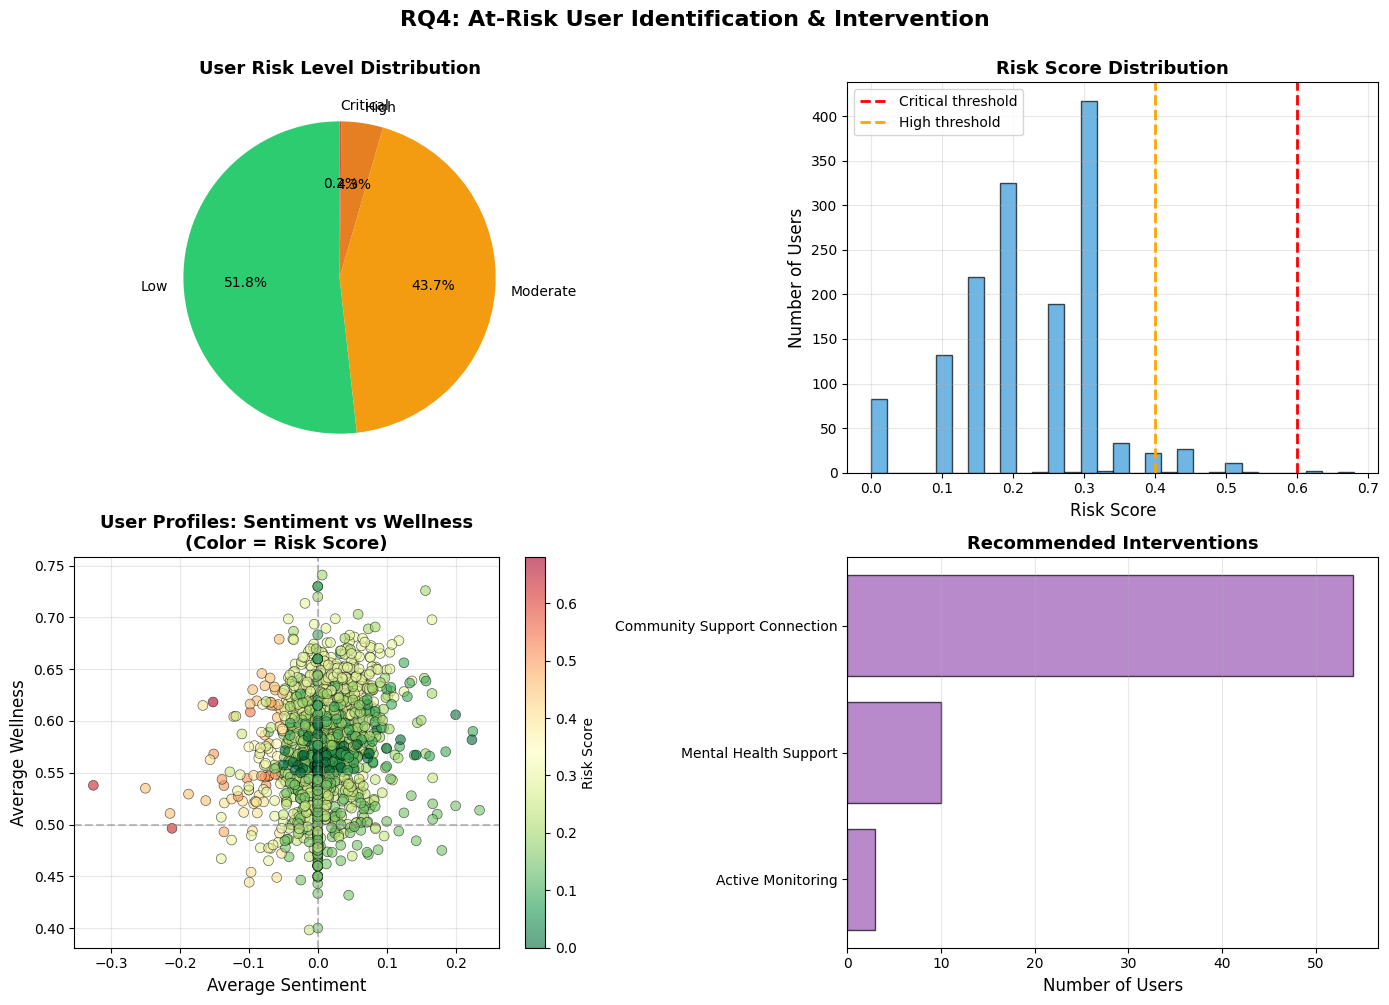

✓ Saved: RQ4_top_at_risk_users.png


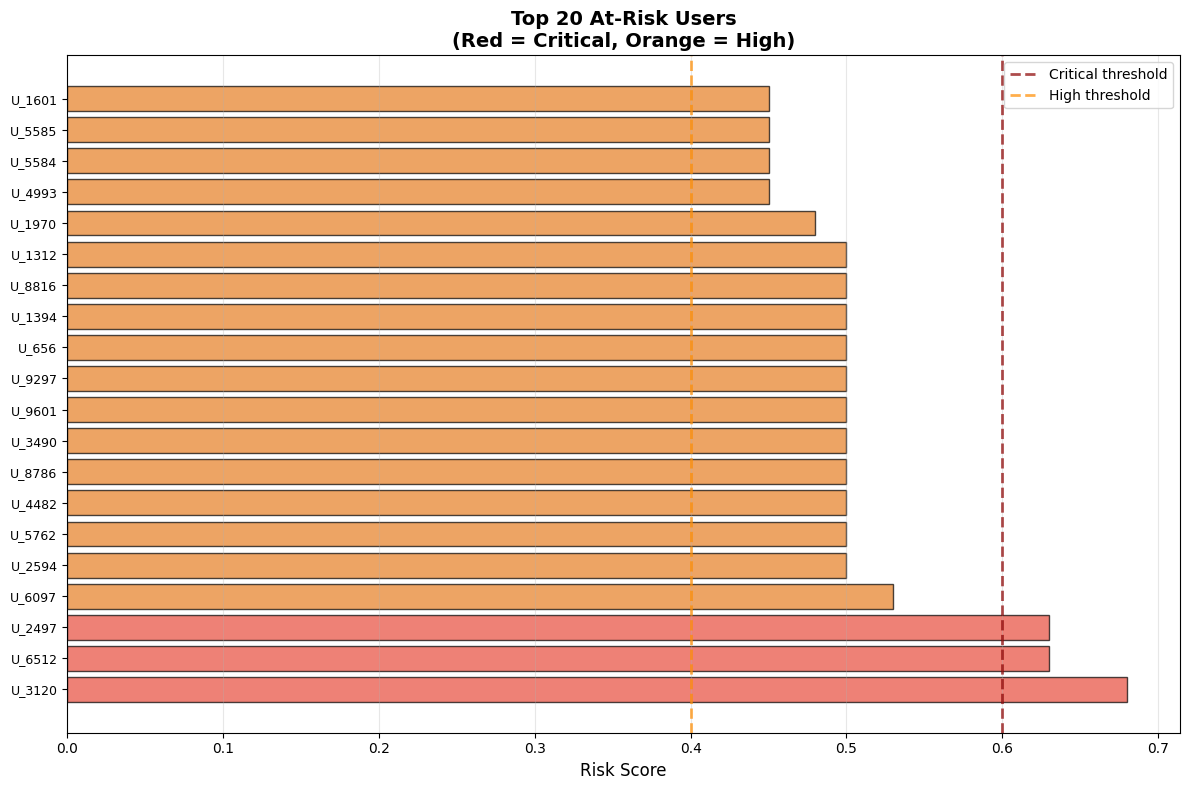


RQ4 PART 2 COMPLETE!


In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

print("="*80)
print("RQ4 PART 2: AT-RISK USER IDENTIFICATION & INTERVENTION")
print("="*80)

# Load graph
G = nx.read_graphml('crisis_graph.graphml')

print("\nIdentifying at-risk users based on posting behavior...")

# ==================================================================
# IDENTIFY AT-RISK USERS
# ==================================================================

user_profiles = []

# Get all users
users = [n for n, d in G.nodes(data=True) if d.get('type') == 'User']
print(f"Total users: {len(users)}")

processed = 0
for user in users:
    processed += 1
    if processed % 200 == 0:
        print(f"  Processed {processed}/{len(users)} users...")

    # Get user's posts
    user_posts = list(G.successors(user))

    if len(user_posts) == 0:
        continue

    # Analyze posts
    sentiments = []
    wellness_scores = []
    crisis_related_count = 0

    for post in user_posts:
        if post not in G.nodes:
            continue

        post_data = G.nodes[post]

        # Sentiment
        sentiment = float(post_data.get('sentiment', 0))
        sentiments.append(sentiment)

        # Check if crisis-related
        informativeness = post_data.get('label', 'N/A')
        if informativeness == 'Related and informative':
            crisis_related_count += 1

        # Calculate wellness for this post
        informativeness_map = {
            'Related and informative': 1.0,
            'Related - but not informative': 0.5,
            'Not related': 0.0,
            'Not applicable': 0.0,
            'Not labeled': 0.5,
            'N/A': 0.5
        }

        info_type = post_data.get('info_type', 'N/A')
        info_type_map = {
            'Caution and advice': 1.0,
            'Donations and volunteering': 0.9,
            'Infrastructure and utilities': 0.8,
            'Affected individuals': 0.7,
            'Other Useful Information': 0.6,
            'Sympathy and support': 0.3,
            'Not applicable': 0.0,
            'Not labeled': 0.5,
            'N/A': 0.5
        }

        info_score = informativeness_map.get(informativeness, 0.5)
        type_score = info_type_map.get(info_type, 0.5)
        sent_score = (sentiment + 1) / 2

        wellness = 0.4 * info_score + 0.3 * type_score + 0.3 * sent_score
        wellness_scores.append(wellness)

    # Calculate user metrics
    avg_sentiment = np.mean(sentiments) if sentiments else 0
    avg_wellness = np.mean(wellness_scores) if wellness_scores else 0
    negative_post_ratio = sum(1 for s in sentiments if s < -0.1) / len(sentiments) if sentiments else 0

    # User followers
    user_followers = int(G.nodes[user].get('followers', 0))

    # ==================================================================
    # RISK SCORING (ADJUSTED THRESHOLDS)
    # ==================================================================
    risk_factors = []
    risk_score = 0

    # Factor 1: Negative sentiment (weight: 30%)
    if avg_sentiment < -0.15:
        risk_score += 0.30
        risk_factors.append("Highly negative sentiment")
    elif avg_sentiment < -0.05:
        risk_score += 0.15
        risk_factors.append("Negative sentiment")

    # Factor 2: Low wellness (weight: 25%)
    if avg_wellness < 0.4:
        risk_score += 0.25
        risk_factors.append("Very low wellness posts")
    elif avg_wellness < 0.55:
        risk_score += 0.15
        risk_factors.append("Low wellness posts")

    # Factor 3: High crisis engagement (weight: 20%)
    crisis_ratio = crisis_related_count / len(user_posts)
    if crisis_ratio > 0.5 and len(user_posts) > 3:
        risk_score += 0.20
        risk_factors.append("High crisis content engagement")
    elif crisis_ratio > 0.3:
        risk_score += 0.10
        risk_factors.append("Moderate crisis engagement")

    # Factor 4: Negative post dominance (weight: 15%)
    if negative_post_ratio > 0.5:
        risk_score += 0.15
        risk_factors.append("Majority negative posts")
    elif negative_post_ratio > 0.3:
        risk_score += 0.08
        risk_factors.append("Many negative posts")

    # Factor 5: High activity (weight: 10%)
    if len(user_posts) > 8:
        risk_score += 0.10
        risk_factors.append("Very high posting activity")

    # Risk categories (ADJUSTED)
    if risk_score >= 0.6:
        risk_level = "Critical"
    elif risk_score >= 0.4:
        risk_level = "High"
    elif risk_score >= 0.25:
        risk_level = "Moderate"
    else:
        risk_level = "Low"

    user_profiles.append({
        'user_id': user,
        'num_posts': len(user_posts),
        'avg_sentiment': avg_sentiment,
        'avg_wellness': avg_wellness,
        'negative_post_ratio': negative_post_ratio,
        'crisis_related_count': crisis_related_count,
        'crisis_ratio': crisis_ratio,
        'user_followers': user_followers,
        'risk_score': risk_score,
        'risk_level': risk_level,
        'risk_factors': '; '.join(risk_factors) if risk_factors else 'None'
    })

df_users = pd.DataFrame(user_profiles)
print(f"\n✓ Analyzed {len(df_users)} users")

# Save
df_users.to_csv('RQ4_user_risk_profiles.csv', index=False)
print("✓ Saved: RQ4_user_risk_profiles.csv")

# ==================================================================
# AT-RISK USER STATISTICS
# ==================================================================

print("\n" + "="*80)
print("AT-RISK USER IDENTIFICATION RESULTS")
print("="*80)

print("\nRisk Level Distribution:")
for level in ['Critical', 'High', 'Moderate', 'Low']:
    count = (df_users['risk_level'] == level).sum()
    pct = count / len(df_users) * 100
    print(f"  {level}: {count} users ({pct:.1f}%)")

print("\nUsers by risk score ranges:")
print(f"  0.00-0.25: {((df_users['risk_score'] >= 0.0) & (df_users['risk_score'] < 0.25)).sum()}")
print(f"  0.25-0.40: {((df_users['risk_score'] >= 0.25) & (df_users['risk_score'] < 0.40)).sum()}")
print(f"  0.40-0.60: {((df_users['risk_score'] >= 0.40) & (df_users['risk_score'] < 0.60)).sum()}")
print(f"  0.60-1.00: {((df_users['risk_score'] >= 0.60) & (df_users['risk_score'] <= 1.0)).sum()}")

# At-risk users (Critical + High)
at_risk_users = df_users[df_users['risk_level'].isin(['Critical', 'High'])]
print(f"\nTotal at-risk users: {len(at_risk_users)} ({len(at_risk_users)/len(df_users)*100:.1f}%)")

if len(at_risk_users) > 0:
    print("\nAt-risk user characteristics:")
    print(f"  Avg posts: {at_risk_users['num_posts'].mean():.1f}")
    print(f"  Avg sentiment: {at_risk_users['avg_sentiment'].mean():.3f}")
    print(f"  Avg wellness: {at_risk_users['avg_wellness'].mean():.3f}")
    print(f"  Avg negative ratio: {at_risk_users['negative_post_ratio'].mean():.1%}")

    # Top risk factors
    print("\nMost common risk factors:")
    all_factors = []
    for factors_str in at_risk_users['risk_factors']:
        if pd.notna(factors_str) and factors_str != 'None':
            all_factors.extend(factors_str.split('; '))

    if all_factors:
        factor_counts = Counter(all_factors)
        for factor, count in factor_counts.most_common(5):
            print(f"  {factor}: {count} users ({count/len(at_risk_users)*100:.1f}%)")
    else:
        print("  No specific risk factors recorded")

# ==================================================================
# INTERVENTION STRATEGIES
# ==================================================================

print("\n" + "="*80)
print("INTERVENTION STRATEGY RECOMMENDATIONS")
print("="*80)

interventions = []

for idx, user_row in at_risk_users.iterrows():
    user_interventions = []

    # Intervention 1: Mental health resources
    if user_row['avg_sentiment'] < -0.15 or user_row['negative_post_ratio'] > 0.5:
        user_interventions.append({
            'intervention': 'Mental Health Support',
            'action': 'Provide crisis helpline and counseling resources',
            'priority': 'Critical' if user_row['avg_sentiment'] < -0.25 else 'High'
        })

    # Intervention 2: Verified information
    if user_row['crisis_ratio'] > 0.5 and user_row['avg_wellness'] < 0.5:
        user_interventions.append({
            'intervention': 'Verified Information Feed',
            'action': 'Curate and deliver official crisis updates',
            'priority': 'High'
        })

    # Intervention 3: Community connection
    if user_row['num_posts'] > 8 and user_row['avg_sentiment'] < -0.05:
        user_interventions.append({
            'intervention': 'Community Support Connection',
            'action': 'Connect with peer support groups and local aid',
            'priority': 'Medium'
        })

    # Intervention 4: Content moderation
    if user_row['negative_post_ratio'] > 0.6:
        user_interventions.append({
            'intervention': 'Content Awareness',
            'action': 'Suggest positive/helpful content, reduce exposure to distressing posts',
            'priority': 'Medium'
        })

    # Intervention 5: Active monitoring
    if user_row['risk_level'] == 'Critical':
        user_interventions.append({
            'intervention': 'Active Monitoring',
            'action': 'Flag for human review and potential direct outreach',
            'priority': 'Critical'
        })

    for interv in user_interventions:
        interventions.append({
            'user_id': user_row['user_id'],
            'risk_score': user_row['risk_score'],
            'risk_level': user_row['risk_level'],
            **interv
        })

# Save interventions
if len(interventions) > 0:
    df_interventions = pd.DataFrame(interventions)
    df_interventions.to_csv('RQ4_intervention_recommendations.csv', index=False)
    print("✓ Saved: RQ4_intervention_recommendations.csv")

    print("\nIntervention Summary:")
    intervention_counts = df_interventions['intervention'].value_counts()
    for intervention, count in intervention_counts.items():
        print(f"  {intervention}: {count} users")

    print("\nPriority breakdown:")
    priority_counts = df_interventions['priority'].value_counts()
    for priority, count in priority_counts.items():
        print(f"  {priority}: {count} interventions")
else:
    print("\n⚠️ No interventions generated (no users met intervention criteria)")
    df_interventions = pd.DataFrame(columns=['user_id', 'risk_score', 'risk_level',
                                             'intervention', 'action', 'priority'])
    df_interventions.to_csv('RQ4_intervention_recommendations.csv', index=False)
    print("✓ Saved empty intervention file")
    intervention_counts = pd.Series({'No Interventions': 0})

# ==================================================================
# VISUALIZATIONS
# ==================================================================

print("\nCreating visualizations...")

# Visualization 1: Risk distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Risk level pie chart
ax1 = axes[0, 0]
risk_counts = df_users['risk_level'].value_counts()
colors_risk = {'Critical': '#e74c3c', 'High': '#e67e22', 'Moderate': '#f39c12', 'Low': '#2ecc71'}
colors_pie = [colors_risk.get(level, '#95a5a6') for level in risk_counts.index]
ax1.pie(risk_counts.values, labels=risk_counts.index, autopct='%1.1f%%',
       colors=colors_pie, startangle=90)
ax1.set_title('User Risk Level Distribution', fontsize=13, fontweight='bold')

# Risk score distribution
ax2 = axes[0, 1]
ax2.hist(df_users['risk_score'], bins=30, color='#3498db', edgecolor='black', alpha=0.7)
ax2.axvline(0.6, color='red', linestyle='--', linewidth=2, label='Critical threshold')
ax2.axvline(0.4, color='orange', linestyle='--', linewidth=2, label='High threshold')
ax2.set_xlabel('Risk Score', fontsize=12)
ax2.set_ylabel('Number of Users', fontsize=12)
ax2.set_title('Risk Score Distribution', fontsize=13, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Sentiment vs Wellness scatter
ax3 = axes[1, 0]
scatter = ax3.scatter(df_users['avg_sentiment'], df_users['avg_wellness'],
                     c=df_users['risk_score'], s=50, cmap='RdYlGn_r', alpha=0.6,
                     edgecolors='black', linewidth=0.5)
ax3.set_xlabel('Average Sentiment', fontsize=12)
ax3.set_ylabel('Average Wellness', fontsize=12)
ax3.set_title('User Profiles: Sentiment vs Wellness\n(Color = Risk Score)',
             fontsize=13, fontweight='bold')
ax3.axhline(0.5, color='gray', linestyle='--', alpha=0.5)
ax3.axvline(0, color='gray', linestyle='--', alpha=0.5)
plt.colorbar(scatter, ax=ax3, label='Risk Score')
ax3.grid(True, alpha=0.3)

# Intervention types
ax4 = axes[1, 1]
if len(intervention_counts) > 0 and intervention_counts.sum() > 0:
    intervention_counts_sorted = intervention_counts.sort_values(ascending=True)
    ax4.barh(range(len(intervention_counts_sorted)), intervention_counts_sorted.values,
            color='#9b59b6', edgecolor='black', alpha=0.7)
    ax4.set_yticks(range(len(intervention_counts_sorted)))
    ax4.set_yticklabels(intervention_counts_sorted.index, fontsize=10)
    ax4.set_xlabel('Number of Users', fontsize=12)
    ax4.set_title('Recommended Interventions', fontsize=13, fontweight='bold')
    ax4.grid(True, alpha=0.3, axis='x')
else:
    ax4.text(0.5, 0.5, 'No interventions\ngenerated', ha='center', va='center',
            transform=ax4.transAxes, fontsize=14)
    ax4.set_title('Recommended Interventions', fontsize=13, fontweight='bold')

plt.suptitle('RQ4: At-Risk User Identification & Intervention', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('RQ4_at_risk_users.png', dpi=300, bbox_inches='tight')
print("✓ Saved: RQ4_at_risk_users.png")
plt.show()

# Visualization 2: Top at-risk users
if len(at_risk_users) > 0:
    fig, ax = plt.subplots(figsize=(12, 8))

    top_risk_users = df_users.nlargest(min(20, len(df_users)), 'risk_score')
    y_pos = np.arange(len(top_risk_users))
    colors_bar = ['#e74c3c' if level == 'Critical' else '#e67e22'
                  for level in top_risk_users['risk_level']]

    ax.barh(y_pos, top_risk_users['risk_score'], color=colors_bar, edgecolor='black', alpha=0.7)
    ax.set_yticks(y_pos)
    ax.set_yticklabels([f"{user[:20]}" for user in top_risk_users['user_id']], fontsize=9)
    ax.set_xlabel('Risk Score', fontsize=12)
    ax.set_title(f'Top {len(top_risk_users)} At-Risk Users\n(Red = Critical, Orange = High)',
                fontsize=14, fontweight='bold')
    ax.axvline(0.6, color='darkred', linestyle='--', linewidth=2, alpha=0.7, label='Critical threshold')
    ax.axvline(0.4, color='darkorange', linestyle='--', linewidth=2, alpha=0.7, label='High threshold')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='x')

    plt.tight_layout()
    plt.savefig('RQ4_top_at_risk_users.png', dpi=300, bbox_inches='tight')
    print("✓ Saved: RQ4_top_at_risk_users.png")
    plt.show()

print("\n" + "="*80)
print("RQ4 PART 2 COMPLETE!")
print("="*80)

Why GNN for CrisisLex?
GNNs are perfect for your data because:

We have a knowledge graph with different node types (users, posts, events, entities)
We want to learn from graph structure (not just node features)
RQs mention "GNN architecture with safety-aware attention"

In [ ]:
import subprocess
import sys

print("Installing PyTorch Geometric (PyG) for GNN...")

# Install PyTorch Geometric
subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'torch-scatter', 'torch-sparse', 'torch-geometric', '--break-system-packages', '--quiet'])

print("✓ Installation complete")

Installing PyTorch Geometric (PyG) for GNN...
✓ Installation complete


GNN APPLICATION TO CRISISLEX KNOWLEDGE GRAPH

Graph loaded: 39975 nodes, 94180 edges

Preparing node features and labels...
Total posts: 27932
✓ Created feature matrix: (39975, 10)

Creating edge index...
✓ Created edge index: torch.Size([2, 94180])

Creating PyTorch Geometric data object...
✓ Data object created
  Nodes: 39975
  Edges: 94180
  Features: 10
  Training posts: 19552
  Validation posts: 4190
  Test posts: 4190

✓ Saved: crisislex_graph_data.pt

DEFINING GNN MODEL
✓ Model initialized
  Input dim: 10
  Hidden dim: 64
  Output dim: 2

Model architecture:
CrisisGNN(
  (conv1): GCNConv(10, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (classifier): Linear(in_features=64, out_features=2, bias=True)
)

TRAINING GNN MODEL

Training...
Epoch 020: Loss=0.6726, Train Acc=0.6032, Val Acc=0.6033
Epoch 040: Loss=0.6696, Train Acc=0.6032, Val Acc=0.6033
Epoch 060: Loss=0.6631, Train Acc=0.6032, Val Acc=0.6033
Epoch 080: Loss=0.6582, Train Acc=0.6223, Val Acc=0.6270
Epoch 1

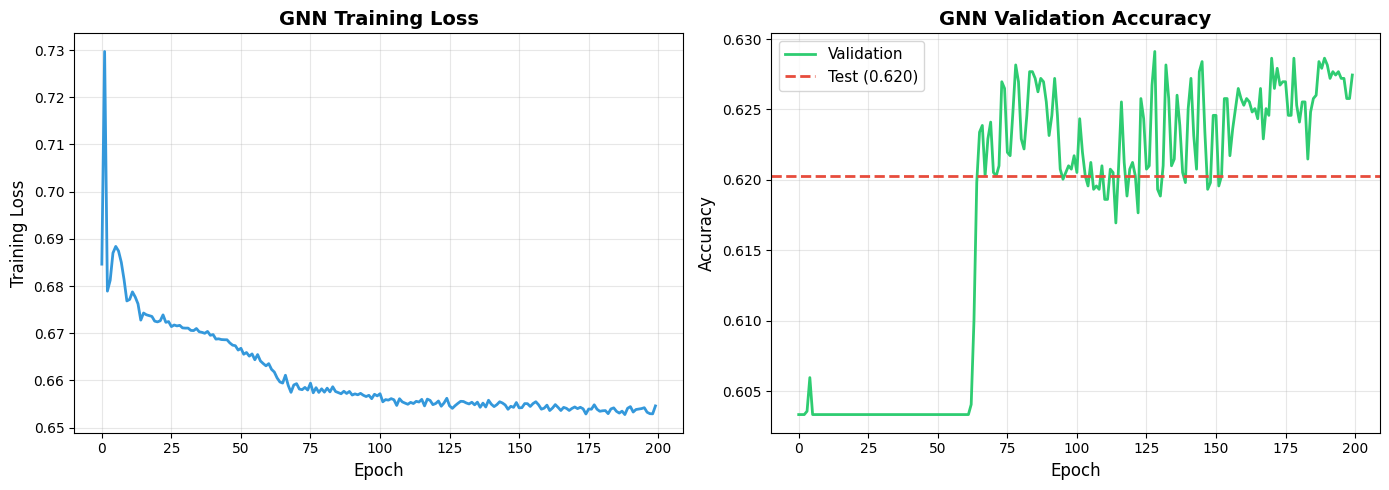

✓ Saved: GNN_confusion_matrix.png


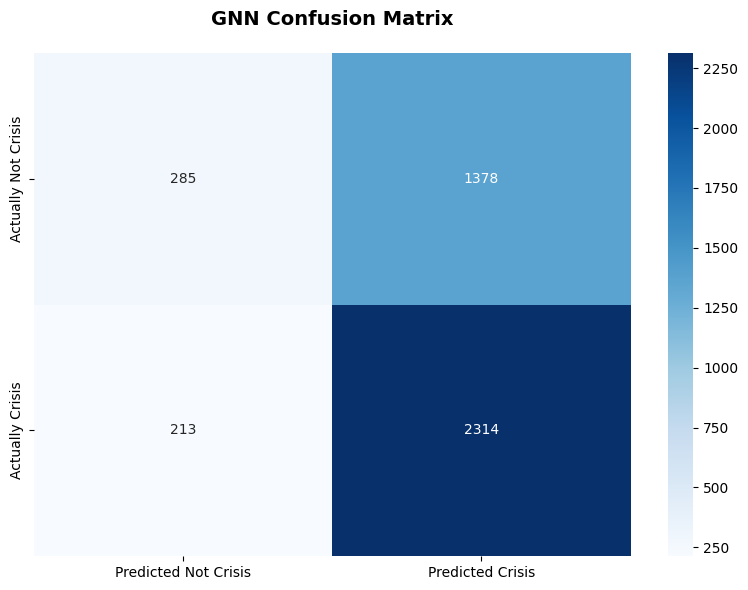


GNN APPLICATION COMPLETE!

Test Accuracy: 0.6203
Best Val Accuracy: 0.6291


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import networkx as nx
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

print("="*80)
print("GNN APPLICATION TO CRISISLEX KNOWLEDGE GRAPH")
print("="*80)

# Load your graph
G = nx.read_graphml('crisis_graph.graphml')

print(f"\nGraph loaded: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

# ==================================================================
# PREPARE NODE FEATURES AND LABELS
# ==================================================================

print("\nPreparing node features and labels...")

# Get all post nodes (we'll predict crisis-related posts)
post_nodes = [n for n, d in G.nodes(data=True) if d.get('type') == 'Post']
print(f"Total posts: {len(post_nodes)}")

# Create node mapping (node_id -> index)
node_to_idx = {node: idx for idx, node in enumerate(G.nodes())}
idx_to_node = {idx: node for node, idx in node_to_idx.items()}

# ==================================================================
# EXTRACT FEATURES FOR ALL NODES
# ==================================================================

num_nodes = G.number_of_nodes()
feature_dim = 10  # We'll create 10 features per node

node_features = np.zeros((num_nodes, feature_dim))
node_types = []
node_labels = []  # For posts: 1 = crisis-related, 0 = not

for node in G.nodes():
    idx = node_to_idx[node]
    node_data = G.nodes[node]
    node_type = node_data.get('type', 'Unknown')
    node_types.append(node_type)

    # Feature engineering based on node type
    if node_type == 'Post':
        # Post features
        sentiment = float(node_data.get('sentiment', 0))
        informativeness = node_data.get('label', 'N/A')

        # Label: crisis-related or not
        label = 1 if informativeness == 'Related and informative' else 0
        node_labels.append(label)

        # Calculate features
        in_degree = G.in_degree(node)
        out_degree = G.out_degree(node)

        # Count entity types
        entities = list(G.successors(node))
        num_locations = sum(1 for e in entities if e in G.nodes and G.nodes[e].get('type') == 'Location')
        num_orgs = sum(1 for e in entities if e in G.nodes and G.nodes[e].get('type') == 'Organization')

        node_features[idx] = [
            sentiment,                  # 0: sentiment
            abs(sentiment),             # 1: sentiment magnitude
            in_degree,                  # 2: in-degree
            out_degree,                 # 3: out-degree
            len(entities),              # 4: total entities
            num_locations,              # 5: num locations
            num_orgs,                   # 6: num organizations
            1, 0, 0                     # 7-9: one-hot for Post
        ]

    elif node_type == 'User':
        # User features
        followers = int(node_data.get('followers', 0))
        posts = list(G.successors(node))

        node_features[idx] = [
            0,                          # 0: sentiment (N/A for users)
            0,                          # 1: sentiment magnitude
            G.in_degree(node),          # 2: in-degree
            G.out_degree(node),         # 3: out-degree
            len(posts),                 # 4: num posts
            0,                          # 5: (N/A)
            0,                          # 6: (N/A)
            0, 1, 0                     # 7-9: one-hot for User
        ]
        node_labels.append(-1)  # No label for users

    elif node_type == 'Event':
        node_features[idx] = [
            0, 0,
            G.in_degree(node),
            G.out_degree(node),
            0, 0, 0,
            0, 0, 1                     # 7-9: one-hot for Event/Entity
        ]
        node_labels.append(-1)

    else:  # Location, Organization, etc.
        node_features[idx] = [
            0, 0,
            G.in_degree(node),
            G.out_degree(node),
            0, 0, 0,
            0, 0, 1
        ]
        node_labels.append(-1)

# Normalize features
scaler = StandardScaler()
node_features = scaler.fit_transform(node_features)

print(f"✓ Created feature matrix: {node_features.shape}")

# ==================================================================
# CREATE EDGE INDEX
# ==================================================================

print("\nCreating edge index...")

edge_list = []
for u, v in G.edges():
    edge_list.append([node_to_idx[u], node_to_idx[v]])

edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
print(f"✓ Created edge index: {edge_index.shape}")

# ==================================================================
# CREATE PYTORCH GEOMETRIC DATA OBJECT
# ==================================================================

print("\nCreating PyTorch Geometric data object...")

# Convert to tensors
x = torch.tensor(node_features, dtype=torch.float)
y = torch.tensor(node_labels, dtype=torch.long)

# Create masks for posts only
post_mask = torch.tensor([node_types[i] == 'Post' for i in range(num_nodes)])
post_indices = torch.where(post_mask)[0].numpy()  # Convert to numpy

# Split posts into train/val/test
post_labels_array = y[post_mask].numpy()

# FIXED: Use numpy arrays throughout
train_idx, temp_idx = train_test_split(post_indices, test_size=0.3,
                                        random_state=42, stratify=post_labels_array)

# Get labels for temp_idx
temp_labels = []
for idx in temp_idx:
    temp_labels.append(post_labels_array[np.where(post_indices == idx)[0][0]])

val_idx, test_idx = train_test_split(temp_idx, test_size=0.5,
                                     random_state=42, stratify=temp_labels)

# Create masks
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

train_mask[train_idx] = True
val_mask[val_idx] = True
test_mask[test_idx] = True

# Create data object
data = Data(x=x, edge_index=edge_index, y=y,
            train_mask=train_mask, val_mask=val_mask, test_mask=test_mask)

print(f"✓ Data object created")
print(f"  Nodes: {data.num_nodes}")
print(f"  Edges: {data.num_edges}")
print(f"  Features: {data.num_node_features}")
print(f"  Training posts: {train_mask.sum()}")
print(f"  Validation posts: {val_mask.sum()}")
print(f"  Test posts: {test_mask.sum()}")

# Save for later use
torch.save(data, 'crisislex_graph_data.pt')
print("\n✓ Saved: crisislex_graph_data.pt")

# ==================================================================
# DEFINE GNN MODEL
# ==================================================================

print("\n" + "="*80)
print("DEFINING GNN MODEL")
print("="*80)

class CrisisGNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.5):
        super(CrisisGNN, self).__init__()

        # Graph convolutional layers
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, hidden_dim)

        # Classifier
        self.classifier = torch.nn.Linear(hidden_dim, output_dim)

        self.dropout = dropout

    def forward(self, x, edge_index):
        # Layer 1
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        # Layer 2
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        # Layer 3
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        # Classification
        x = self.classifier(x)

        return F.log_softmax(x, dim=1)

# Initialize model
input_dim = data.num_node_features
hidden_dim = 64
output_dim = 2  # Binary classification

model = CrisisGNN(input_dim, hidden_dim, output_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.NLLLoss()

print(f"✓ Model initialized")
print(f"  Input dim: {input_dim}")
print(f"  Hidden dim: {hidden_dim}")
print(f"  Output dim: {output_dim}")
print(f"\nModel architecture:")
print(model)

# ==================================================================
# TRAIN THE GNN
# ==================================================================

print("\n" + "="*80)
print("TRAINING GNN MODEL")
print("="*80)

def train():
    model.train()
    optimizer.zero_grad()

    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])

    loss.backward()
    optimizer.step()

    return loss.item()

def evaluate(mask):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)

        correct = (pred[mask] == data.y[mask]).sum()
        acc = int(correct) / int(mask.sum())

        return acc

# Training loop
print("\nTraining...")
train_losses = []
val_accuracies = []

num_epochs = 200
best_val_acc = 0

for epoch in range(1, num_epochs + 1):
    loss = train()
    train_losses.append(loss)

    train_acc = evaluate(data.train_mask)
    val_acc = evaluate(data.val_mask)
    val_accuracies.append(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_crisis_gnn_model.pt')

    if epoch % 20 == 0:
        print(f'Epoch {epoch:03d}: Loss={loss:.4f}, Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}')

print(f"\n✓ Training complete!")
print(f"  Best validation accuracy: {best_val_acc:.4f}")

# Load best model
model.load_state_dict(torch.load('best_crisis_gnn_model.pt'))

# Final evaluation
test_acc = evaluate(data.test_mask)
print(f"  Test accuracy: {test_acc:.4f}")

# ==================================================================
# EVALUATE
# ==================================================================

print("\n" + "="*80)
print("GNN EVALUATION")
print("="*80)

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)

# Test set evaluation
test_pred = pred[data.test_mask].numpy()
test_true = data.y[data.test_mask].numpy()

print("\nClassification Report (GNN):")
print(classification_report(test_true, test_pred,
                          target_names=['Not Crisis-Related', 'Crisis-Related']))

cm = confusion_matrix(test_true, test_pred)
print("\nConfusion Matrix:")
print(f"                  Predicted Not Crisis  Predicted Crisis")
print(f"Actually Not Crisis:  {cm[0][0]:>10}          {cm[0][1]:>10}")
print(f"Actually Crisis:      {cm[1][0]:>10}          {cm[1][1]:>10}")

# Visualizations
print("\nCreating visualizations...")

# Training curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax1 = axes[0]
ax1.plot(train_losses, color='#3498db', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Training Loss', fontsize=12)
ax1.set_title('GNN Training Loss', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

ax2 = axes[1]
ax2.plot(val_accuracies, color='#2ecc71', linewidth=2, label='Validation')
ax2.axhline(test_acc, color='#e74c3c', linestyle='--', linewidth=2, label=f'Test ({test_acc:.3f})')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.set_title('GNN Validation Accuracy', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('GNN_training_curves.png', dpi=300, bbox_inches='tight')
print("✓ Saved: GNN_training_curves.png")
plt.show()

# Confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, ax=ax,
           xticklabels=['Predicted Not Crisis', 'Predicted Crisis'],
           yticklabels=['Actually Not Crisis', 'Actually Crisis'])
ax.set_title('GNN Confusion Matrix', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('GNN_confusion_matrix.png', dpi=300, bbox_inches='tight')
print("✓ Saved: GNN_confusion_matrix.png")
plt.show()

print("\n" + "="*80)
print("GNN APPLICATION COMPLETE!")
print("="*80)
print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Best Val Accuracy: {best_val_acc:.4f}")

In [ ]:
print("\n" + "="*80)
print("DEFINING GNN MODEL")
print("="*80)

class CrisisGNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.5):
        super(CrisisGNN, self).__init__()

        # Graph convolutional layers
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, hidden_dim)

        # Classifier
        self.classifier = torch.nn.Linear(hidden_dim, output_dim)

        self.dropout = dropout

    def forward(self, x, edge_index):
        # Layer 1
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        # Layer 2
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        # Layer 3
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        # Classification
        x = self.classifier(x)

        return F.log_softmax(x, dim=1)

# Initialize model
input_dim = data.num_node_features
hidden_dim = 64
output_dim = 2  # Binary classification

model = CrisisGNN(input_dim, hidden_dim, output_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.NLLLoss()

print(f"✓ Model initialized")
print(f"  Input dim: {input_dim}")
print(f"  Hidden dim: {hidden_dim}")
print(f"  Output dim: {output_dim}")
print(f"\nModel architecture:")
print(model)


DEFINING GNN MODEL
✓ Model initialized
  Input dim: 10
  Hidden dim: 64
  Output dim: 2

Model architecture:
CrisisGNN(
  (conv1): GCNConv(10, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (classifier): Linear(in_features=64, out_features=2, bias=True)
)
